Shiva Pal

Teammate: Brian Cheung

# Part 3:Twitter Application Development

In [1]:
# Necessary Packages
# install.packages("shiny")
# install.packages("twitteR")
# install.packages("rtweet")
# install.packages("ggmap")
# install.packages("maptools")
# install.packages("maps")
# install.packages("viridis")
# install.packages("ggthemes")
# install.packages("fiftystater")
# install.packages("reshape2")

In [3]:
# All libraries
library(shiny)
library(twitteR)
library(rtweet)
library("ggmap")
library("maptools")
library(maps)
library(viridis)
library(ggthemes)
library(fiftystater)
library(reshape2)

In [41]:
# API keys
#Please provide your owne keys
consumer_key <- ""
consumer_secret <- ""
access_token <- ""
access_secret <- ""
setup_twitter_oauth(consumer_key, consumer_secret, access_token, access_secret)
token <- create_token(
    app = "",
    consumer_key = "",
    consumer_secret ="",
    access_token = "",
    access_secret = "")
API_KEY = ""
register_google(key = API_KEY)

[1] "Using direct authentication"


In [ ]:
# Key Words to search for on twitter 
# Use rtweet API to help collect data
# Filtered out retweets and geocode coords to only within the USA

terms_search = "flu OR influenza OR fluszn OR fluseason OR fluvaccine OR fluview OR fightflu OR flushot -filter:retweets"
flu <- search_tweets(
  terms_search, n = 20000, include_rts = FALSE, retryonratelimit=TRUE, 
    lang = "en", geocode = lookup_coords("usa"), token = token 
)

In [ ]:
# Using rtweet function, obtain the latitude and longitude from available Users
# Append the latitude and longitude into the dataframe
latlong <- lat_lng(flu)
flu$lat <- latlong$lat
flu$lng <- latlong$lng

In [ ]:
# Save the raw result from tweets collected into csv file

save_as_csv(flu, file_name = "rawTweetSearchResults.csv", prepend_ids = TRUE, na="", fileEncoding = "UTF-8")

Filter the data collected

In [42]:
FluData <- as.data.frame(read.csv("Files/rawTweetSearchResults.csv"))

FluData <- FluData[c(0:3500),]

# Create list to store information
user_id <- list()
status_id <- list()
created_at <- list()
text <- list()
screen_name <- list()
location <- list()
lng <- list()
lat <- list()
state <- list()

Function to help verify if location is valid

In [652]:
cleanData <- function(x){
    lat <- FluData[x,"lat"]
    lng <- FluData[x,"lng"]
    g <- c(lng, lat)
    # if default lat and lng does not exist, find it with geocode
    if (is.na(lat) || is.na(lng)){
        # Get the user set location
        location <- tolower(as.character(FluData[x, "location"]))
        filterlocations <- c('canada', 'usa', 'earth','home','u.s.a' 'united states','far','thib', 'us', 'on a mission')
        if (location %in% filterlocations){
            return (NA)
        }
        g <- as.numeric(geocode(location))
        # if geocode can't find the location return NA
        if(is.na(g[1]) || is.na(g[2])){
            return (NA)
        }
        # Set long and lat
        lng = g[1]
        lat = g[2]
            
    }
    # revgeo the coord
    reverseGeo <- revgeocode(g, output = "address")
    
    address <- unlist(strsplit(reverseGeo, ", "))
    # Obtain the country and check if it is in the USA
    country <- address[4]
    # If the location is in the USA
    if (is.na(country) ||country == "USA"){
        state_PostalCode <-unlist(strsplit(address[3], " "))
        # Check state name
        stateName <- tolower(state.name[match(state_PostalCode[1],state.abb)])
        if (is.na(stateName)){
            stateName <- tolower(address[2])
        }
        # if the state is not part of the US
        if(!stateName %in% unique(fifty_states$id)){
            return (NA)
        }
        
        l <- c(as.character(FluData[x,"user_id"]), as.character(FluData[x,"status_id"]),
                   as.character(FluData[x,"created_at"]), as.character(FluData[x,"text"]),
                   as.character(FluData[x,"screen_name"]),
                   as.character(FluData[x,"location"]), as.character(g[1]), as.character(g[2]), stateName)
        return (l)
    }
    return (NA)
}

In [653]:
# Loop through dataframe 
for (row in 1:nrow(FluData)){
    # apply the function
    f <- lapply(row, cleanData)
    # If function return NA, there is no valid location
    if (!is.na(f)){  
        # Append information to list
        user_id <- c(user_id, f[[1]][1])
        status_id <- c(status_id, f[[1]][2])
        created_at <- c(created_at, f[[1]][3])
        text <- c(text, f[[1]][4])
        screen_name <- c(screen_name, f[[1]][5])
        location <- c(location, f[[1]][6])
        lng <- c(lng, f[[1]][7])
        lat <- c(lat, f[[1]][8])
        state <- c(state, f[[1]][9])
        }
}

Source : https://maps.googleapis.com/maps/api/geocode/json?address=burbank,+wa&key=xxx
Multiple addresses found, the first will be returned:
  12 5th Ave, Pasco, WA 99301, USA
  165 Main St, Pasco, WA 99301, USA
  12 5th St, Burbank, WA 99323, USA
  Burbank, WA 99323, USA
  Walla Walla County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=boston,+ma&key=xxx
Multiple addresses found, the first will be returned:
  1 Cambridge St, Boston, MA 02114, USA
  Unnamed Road, Boston, MA 02203,

  Allegheny County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=pittsburgh,+pennsylvania,+usa&key=xxx
Multiple addresses found, the first will be returned:
  572-598 Grant St, Pittsburgh, PA 15219, USA
  572 Grant St, Pittsburgh, PA 15219, USA
  584 Grant St, Pittsburgh, PA 15219, USA
  Grant St, Pittsburgh, PA 15219, USA
  Downtown, Pittsburgh, PA, USA
  Pittsburgh, PA 15219, USA
  Pittsburgh, PA, USA
  Allegheny County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=pittsburgh,+pennsylvania,+usa&key=xxx
Multiple addresses found, the first will be returned:
  572-598 Grant St, Pittsburgh, PA 15219, USA
  572 Grant St, Pittsburgh, PA 15219, USA
  584 Grant St, Pittsburgh, PA 15219, USA
  Grant St, Pittsburgh, PA 15219, USA
  Downtown, Pittsburgh, PA, USA
  Pittsburgh, PA 15219, USA
  Pittsburgh, PA, USA
  Allegheny County, PA, USA
  Pennsylvania, USA
  Unit

  Kansas City, MO, USA
  Jackson County, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=kansas+city,+mo&key=xxx
Multiple addresses found, the first will be returned:
  1200 Oak St, Kansas City, MO 64106, USA
  400 E 12th St, Kansas City, MO 64106, USA
  1205 Oak St, Kansas City, MO 64106, USA
  498-400 E 12th St, Kansas City, MO 64106, USA
  Kansas City, MO 64106, USA
  Downtown Kansas City, Kansas City, MO, USA
  Kaw Township, MO, USA
  Kansas City, MO, USA
  Jackson County, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=mora,+nm&key=xxx
Multiple addresses found, the first will be returned:
  278-292 NM-518, Mora, NM 87732, USA
  309 NM-518, Mora, NM 87732, USA
  280 NM-518, Mora, NM 87732, USA
  NM-434, Mora, NM 87732, USA
  Mora, NM 87732, USA
  Ledoux, NM 87732, USA
  Mora County, NM, USA
  New Mexico, USA
  United States
Source : https://maps.googleapis.com/maps/

  The Brink Lounge, 701 E Washington Ave, Madison, WI 53703, USA
  701 E Washington Ave, Madison, WI 53703, USA
  731 E Washington Ave, Madison, WI 53703, USA
  E Washington Ave, Madison, WI 53703, USA
  Marquette, Madison, WI, USA
  Madison, WI 53703, USA
  Madison, WI, USA
  Dane County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=the+brink&key=xxx
Multiple addresses found, the first will be returned:
  The Brink Lounge, 701 E Washington Ave, Madison, WI 53703, USA
  701 E Washington Ave, Madison, WI 53703, USA
  731 E Washington Ave, Madison, WI 53703, USA
  E Washington Ave, Madison, WI 53703, USA
  Marquette, Madison, WI, USA
  Madison, WI 53703, USA
  Madison, WI, USA
  Dane County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=eau+claire,+wisconsin&key=xxx
Multiple addresses found, the first will be returned:
  333 Gibson St, Eau Claire, WI 54701, USA
  2

  Downtown, Calgary, AB, Canada
  Calgary, AB, Canada
  Division No. 6, AB, Canada
  Alberta, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=calgary,+alberta&key=xxx
Multiple addresses found, the first will be returned:
  400-444 5 Ave SW, Calgary, AB T2P 0L6, Canada
  445 5 Ave SW, Calgary, AB T2P 2V1, Canada
  EB 5 Av SW @ 4 St SW, Calgary, AB T2P 0S1, Canada
  414 5 Ave SW, Calgary, AB T2P, Canada
  441 5 Ave SW, Calgary, AB T2P, Canada
  Calgary, AB T2P 0L6, Canada
  Downtown Commercial, Calgary, AB, Canada
  Calgary, AB T2P, Canada
  Downtown, Calgary, AB, Canada
  Calgary, AB, Canada
  Division No. 6, AB, Canada
  Alberta, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=calgary,+alberta&key=xxx
Multiple addresses found, the first will be returned:
  400-444 5 Ave SW, Calgary, AB T2P 0L6, Canada
  445 5 Ave SW, Calgary, AB T2P 2V1, Canada
  EB 5 Av SW @ 4 St SW, Calgary, AB T2P 0S1, Canada
  414 5 Ave SW, Calga

  Co. Offaly, Ireland
  Ireland
Source : https://maps.googleapis.com/maps/api/geocode/json?address=texarkana&key=xxx
Multiple addresses found, the first will be returned:
  48 central mall, Texarkana, TX 75501, USA
  622 Texas Blvd, Texarkana, TX 75501, USA
  Texas Blvd & W. 7th St, Texarkana, TX 75501, USA
  575 W 7th St, Texarkana, TX 75501, USA
  599-585 W 7th St, Texarkana, TX 75501, USA
  Texarkana, TX, USA
  Texarkana, TX 75501, USA
  Bowie County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fort+collins,+co&key=xxx
Multiple addresses found, the first will be returned:
  203 S Sherwood St, Fort Collins, CO 80521, USA
  204 S Sherwood St, Fort Collins, CO 80521, USA
  206 S Sherwood St, Fort Collins, CO 80521, USA
  Old Town West, Fort Collins, CO, USA
  Fort Collins, CO 80521, USA
  Fort Collins, CO, USA
  Larimer County, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?a

  Big Rock Township, AR, USA
  Pulaski County, AR, USA
  Arkansas, USA
  United States
Multiple addresses found, the first will be returned:
  410 Summers St, Charleston, WV 25301, USA
  411 Summers St, Charleston, WV 25301, USA
  300-398 Summers St, Charleston, WV 25301, USA
  Charleston, WV 25301, USA
  Charleston, WV, USA
  1, WV, USA
  Kanawha County, WV, USA
  West Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=east+lansing,+mi&key=xxx
Multiple addresses found, the first will be returned:
  415 Abbot Rd, East Lansing, MI 48823, USA
  337 Abbot Rd, East Lansing, MI 48823, USA
  409 Park Ln, East Lansing, MI 48823, USA
  347 Abbot Rd, East Lansing, MI 48823, USA
  300-398 Abbot Rd, East Lansing, MI 48823, USA
  Grand River, East Lansing, MI 48823, USA
  East Lansing, MI, USA
  East Lansing, MI 48823, USA
  Ingham County, MI, USA
  Michigan, USA
  United States
Multiple addresses found, the first will be returned:
  743 Raider Dr, Cle

  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+tx&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego,+ca&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Multiple addresses foun

  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=white+plains,+ny&key=xxx
Multiple addresses found, the first will be returned:
  1133 Westchester Ave, White Plains, NY 10605, USA
  1133 Westchester Ave, White Plains, NY 10601, USA
  Main St, White Plains, NY 10601, USA
  Tibbits Park, N Broadway & Lake St, White Plains, NY 10601, United States
  White Plains, NY 10601, USA
  White Plains, NY, USA
  Westchester County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=jonesboro,+arkansas&key=xxx
Multiple addresses found, the first will be returned:
  201-299 S Main St, Jonesboro, AR 72401, USA
  106 Cate Ave, Jonesboro, AR 72401, USA
  188 Cate Ave, Jonesboro, AR 72401, USA
  S Church St, Jonesboro, AR 72401, USA
  Jonesboro, AR, USA
  Jonesboro Township, AR, USA
  Jonesboro, AR 72401, USA
  Craighead County, AR, USA
  Arkansas, USA
  United States
Source : h

  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ohio&key=xxx
Multiple addresses found, the first will be returned:
  1664 Township Hwy 165, Ashley, OH 43003, USA
  Peru Township, OH, USA
  Ashley, OH 43003, USA
  Morrow County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=chicago,+il&key=xxx
Multiple addresses found, the first will be returned:
  55 W Jackson Blvd, Chicago, IL 60604, USA
  Jackson, Chicago, IL 60604, USA
  302 S Federal St, Chicago, IL 60604, USA
  99-55 W Jackson Blvd, Chicago, IL 60604, USA
  Chicago, IL 60604, USA
  Chicago Loop, Chicago, IL, USA
  Chicago, IL, USA
  Cook County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=chicago,+il&key=xxx
Multiple addresses found, the first will be returned:
  55 W Jackson Blvd, Chicago, IL 60604, USA
  Jackson, Chicago, IL 60604, USA
  302 S Federal St, Chicago, IL 60604, US

  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+usa&key=xxx
"washington, usa" not uniquely geocoded, using "washington, usa"
Multiple addresses found, the first will be returned:
  18183 Winton Rd, Leavenworth, WA 98826, USA
  18142 Winton Rd, Leavenworth, WA 98826, USA
  179-27 Jack Pine Lane, Leavenworth, WA 98826, USA
  Leavenworth, WA 98826, USA
  Chelan County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+rochelle,+ny&key=xxx
Multiple addresses found, the first will be returned:
  270 North Ave, New Rochelle, NY 10801, USA
  255 North Ave, New Rochelle, NY 10801, USA
  227 US-1, New Rochelle, NY 10801, USA
  US-1, New Rochelle, NY 10801, USA
  New Rochelle, NY 10801, USA
  

  Round Rock Original Plat, Round Rock, TX 78664, USA
  Round Rock, TX 78664, USA
  Round Rock, TX, USA
  Williamson County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=patterson,+ny&key=xxx
Multiple addresses found, the first will be returned:
  5 Front St, Patterson, NY 12563, USA
  1138 NY-311, Patterson, NY 12563, USA
  1137-1139 NY-311, Patterson, NY 12563, USA
  Patterson, NY 12563, USA
  Patterson, NY, USA
  Putnam County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https:

  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Dieg

  Downtown, Montreal, QC, Canada
  Ville-Marie, Montreal, QC, Canada
  Montreal, QC, Canada
  Quebec, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+jersey,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Jackson, NJ 08527, USA
  Jackson, NJ, USA
  Ocean County, NJ, USA
  New Jersey, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=redwood+city,+ca&key=xxx
Multiple addresses found, the first will be returned:
  1201 Brewster Ave, Redwood City, CA 94062, USA
  U

  102 E Washington Ave, Vinton, VA 24179, USA
  Washington WB at Pollard, Vinton, VA 24179, USA
  104 Gus Nicks Blvd, Vinton, VA 24179, USA
  118 N Pollard St, Vinton, VA 24179, USA
  125 E Washington Ave, Vinton, VA 24179, USA
  161-101 Gus Nicks Blvd, Vinton, VA 24179, USA
  Vinton, VA 24179, USA
  Vinton, VA, USA
  Roanoke County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=salmon+arm,+british+columbia&key=xxx
Multiple addresses found, the first will be returned:
  6210 Trans-Can Hwy NE, Salmon Arm, BC, Canada
  100 Trans-Canada Hwy, Salmon Arm, BC V1E 3B8, Canada
  50 1 St SE, Salmon Arm, BC V1E 1H6, Canada
  1 St SE, Salmon Arm, BC V1E, Canada
  Salmon Arm, BC, Canada
  Salmon Arm, BC V1E, Canada
  Columbia-Shuswap, BC, Canada
  British Columbia, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+jersey,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Jackson, NJ 

  11570 Duenda Rd, San Diego, CA 92127, USA
  11601 Duenda Rd, San Diego, CA 92127, USA
  11592 Duenda Rd, San Diego, CA 92127, USA
  Duenda Rd, San Diego, CA 92127, USA
  Rancho Bernardo, San Diego, CA, USA
  San Diego, CA 92127, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=lemon+grove,+ca&key=xxx
Multiple addresses found, the first will be returned:
  7771 Broadway, Lemon Grove, CA 91945, USA
  7775 Broadway, Lemon Grove, CA 91945, USA
  Broadway & Main St (Lemon Grove Depot), Lemon Grove, CA 91945, USA
  7773 Broadway, Lemon Grove, CA 91945, USA
  Broadway, Lemon Grove, C

Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=rapid+city,+sd&key=xxx
Multiple addresses found, the first will be returned:
  803 St Joseph St, Rapid City, SD 57701, USA
  792 St Joseph St, Rapid City, SD 57701, USA
  861-801 St Joseph St, Rapid City, SD 57701, USA
  Rapid City, SD, USA
  Rapid City, SD 57701, USA
  Pennington County, SD, USA
  South Dakota, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=rapid+city,+sd&key=xxx
Multiple addresses found, the first will be returned:
  803 St Joseph St, Rapid City, SD 57701, USA
  792 St Joseph St, Rapid City, SD 57701, USA
  861-801 St Jo

Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=lancaster,+pa&key=xxx
Multiple addresses found, the first will be returned:
  2761 Church Rd, Bird in Hand, PA 17505, USA
  2782 Church Rd, Bird in Hand, PA 17505, USA
  301-399 N Ronks Rd, Bird in Hand, PA 17505, USA
  Bird in Hand, PA 17505, USA
  Upper Leacock Township, PA, USA
  Lancaster County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=lincoln,+ne&key=xxx
Multiple addresses found, the first will be returned:
  1273 P St, Lincoln, NE 68508, USA
  Wells Fargo Center, 1248 O St, Lincoln, NE 68508

Multiple addresses found, the first will be returned:
  572-598 Grant St, Pittsburgh, PA 15219, USA
  572 Grant St, Pittsburgh, PA 15219, USA
  584 Grant St, Pittsburgh, PA 15219, USA
  Grant St, Pittsburgh, PA 15219, USA
  Downtown, Pittsburgh, PA, USA
  Pittsburgh, PA 15219, USA
  Pittsburgh, PA, USA
  Allegheny County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=st.+albert,+alberta&key=xxx
Multiple addresses found, the first will be returned:
  30 Sir Winston Churchill Ave, St. Albert, AB T8N 3A3, Canada
  4 Glenview Crescent, St. Albert, AB T8N 1B6, Canada
  Grandin Road &Sir Winston Churchill Avenue, St. Albert, AB T8N 3A3, Canada
  30 Sir Winston Churchill Ave, St. Albert, AB T8N, Canada
  Sir Winston Churchill Ave, St. Albert, AB T8N, Canada
  St. Albert, AB T8N 3A3, Canada
  St. Albert, AB, Canada
  St. Albert, AB T8N, Canada
  Division No. 11, AB, Canada
  Alberta, Canada
  Canada
Source : https://maps.googleap

  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be returned:
  1455 Cherry Ln, Walnut Creek, CA 94597, USA
  2902 Cherry Ln, Walnut Creek, CA 94597, USA
  Treat Blvd, Walnut Creek, CA 94596, USA
  Contra Costa Centre, CA, USA
  Walnut Creek, CA 94597, USA
  Contra Costa County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=albuquerque,+new+mexico&key=xxx
Multiple addresses found, the first will be returned:
  301 Central Ave NW, Albuquerque, NM 87102, USA
  301b Central Ave NW, Albuquerque, NM 87102, USA
  299 Central Ave SW, Albuquerque, NM 87102, USA
  300 Central Ave SW, Albuquerque, NM 87102, USA
  Raynolds Addition, Albuquerque, NM 87102, USA
  Albuquerque, NM 87102, USA
  Albuquerque, NM, USA
  Bernalillo County, NM, USA
  New Mexico, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=

  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=toronto,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  100 Queen St W, Toronto, ON M5G 1P5, Canada
  141 Kennedy Ave, Toronto, ON M6R 2L2, Canada
  Bay St At Albert St, Toronto, ON M5H 2N3, Canada
  487 Bay St, Toronto, ON M5G, Canada
  280 The PATH - City Hall, Toronto, ON, Canada
  Toronto, ON M5G, Canada
  Toronto, ON M5G 1P5, Canada
  Downtown, Toronto, ON, Canada
  Old Toronto, Toronto, ON, Canada
  Toronto, ON, Canada
  Toronto Division, Toronto, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA


  Petawawa, ON K8H 1X3, Canada
  Petawawa, ON K8H, Canada
  Petawawa, ON, Canada
  Renfrew County, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=petawawa,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  43 Portage Rd, Petawawa, ON K8H 1X3, Canada
  3446 Petawawa Blvd, Petawawa, ON K8H 1X3, Canada
  3439 Renfrew County Rd 51, Petawawa, ON K8H, Canada
  4-2 Portage Rd, Petawawa, ON K8H 1T3, Canada
  Petawawa, ON K8H 1X3, Canada
  Petawawa, ON K8H, Canada
  Petawawa, ON, Canada
  Renfrew County, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=petawawa,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  43 Portage Rd, Petawawa, ON K8H 1X3, Canada
  3446 Petawawa Blvd, Petawawa, ON K8H 1X3, Canada
  3439 Renfrew County Rd 51, Petawawa, ON K8H, Canada
  4-2 Portage Rd, Petawawa, ON K8H 1T3, Canada
  Petawawa, ON K8H 1X3, Canada
  Pet

Multiple addresses found, the first will be returned:
  Mont du Bu de la Rue, Jersey JE2, Jersey
  St Lawrence, Jersey
  JE2
  Jersey
Multiple addresses found, the first will be returned:
  3223 S Kolin Ave, Chicago, IL 60623, USA
  3259 S Kolin Ave, Chicago, IL 60623, USA
  4313 W 33rd St, Chicago, IL 60623, USA
  Piotrowski Park, 4247 W 31st St, Chicago, IL 60623, USA
  4399-4341 W 33rd St, Chicago, IL 60623, USA
  Little Village, Chicago, IL, USA
  Chicago, IL 60623, USA
  Chicago, IL, USA
  Cook County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=chicago,+il&key=xxx
Multiple addresses found, the first will be returned:
  55 W Jackson Blvd, Chicago, IL 60604, USA
  Jackson, Chicago, IL 60604, USA
  302 S Federal St, Chicago, IL 60604, USA
  99-55 W Jackson Blvd, Chicago, IL 60604, USA
  Chicago, IL 60604, USA
  Chicago Loop, Chicago, IL, USA
  Chicago, IL, USA
  Cook County, IL, USA
  Illinois, USA
  United States
Source

  Ashley, OH 43003, USA
  Morrow County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=edmonton,+alberta&key=xxx
Multiple addresses found, the first will be returned:
  10221 100 St NW, Edmonton, AB T5J 0Y2, Canada
  Edmonton, AB T5J 0Y2, Canada
  Downtown, Edmonton, AB, Canada
  Edmonton, AB T5J, Canada
  Edmonton, AB, Canada
  Division No. 11, AB, Canada
  Alberta, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=edmonton,+alberta&key=xxx
Multiple addresses found, the first will be returned:
  10221 100 St NW, Edmonton, AB T5J 0Y2, Canada
  Edmonton, AB T5J 0Y2, Canada
  Downtown, Edmonton, AB, Canada
  Edmonton, AB T5J, Canada
  Edmonton, AB, Canada
  Division No. 11, AB, Canada
  Alberta, Canada
  Canada
Multiple addresses found, the first will be returned:
  Stump Springs Rd, Lakeshore, CA 93634, USA
  Shaver Lake, CA 93634, USA
  Fresno County, CA, USA
  California, USA
  United States
Sour

  Kings County, Brooklyn, NY, USA
  Brooklyn, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=brooklyn,+ny&key=xxx
Multiple addresses found, the first will be returned:
  58 Brooklyn Ave, Brooklyn, NY 11216, USA
  Brooklyn Ave, Brooklyn, NY 11216, USA
  57 Atlantic Ave, Brooklyn, NY 11216, USA
  Brooklyn, NY 11216, USA
  Bedford-Stuyvesant, Brooklyn, NY, USA
  Kings County, Brooklyn, NY, USA
  Brooklyn, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=edmonton,+alberta,+canada&key=xxx
Multiple addresses found, the first will be returned:
  10221 100 St NW, Edmonton, AB T5J 0Y2, Canada
  Edmonton, AB T5J 0Y2, Canada
  Downtown, Edmonton, AB, Canada
  Edmonton, AB T5J, Canada
  Edmonton, AB, Canada
  Division No. 11, AB, Canada
  Alberta, Canada
  Canada
Multiple addresses found, the first will be returned:
  403 S 6th St, Harrison, 

  100-128 Cokey Rd, Rocky Mount, NC 27801, USA
  Rocky Mount, NC, USA
  12, Rocky Mt, NC, USA
  Rocky Mount, NC 27801, USA
  Edgecombe County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=somewhere+in+the+islands&key=xxx
Multiple addresses found, the first will be returned:
  131 The Island Dr, Pigeon Forge, TN 37863, USA
  Island Dr, Pigeon Forge, TN 37863, USA
  Pigeon Forge, TN, USA
  Sevierville, TN 37863, USA
  Sevier County, TN, USA
  Tennessee, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=georgetown,+ky&key=xxx
Multiple addresses found, the first will be returned:
  136 E Main St, Georgetown, KY 40324, USA
  110 S Court St, Georgetown, KY 40324, USA
  124-126 E Main St, Georgetown, KY 40324, USA
  Georgetown, KY 40324, USA
  Scott County, KY, USA
  Kentucky, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+orleans&key=xxx
Multipl

  Ohio State Capitol, 1 Capitol Square, Columbus, OH 43215, USA
  1 E Capital St, Columbus, OH 43215, USA
  75 E State St, Columbus, OH 43215, USA
  Unnamed Road, Columbus, OH 43215, USA
  Uptown District, Columbus, OH 43215, USA
  Downtown, Columbus, OH 43215, USA
  Columbus, OH 43215, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Multiple addresses found, the first will be returned:
  750 E 11th Ave, Columbus, OH 43211, USA
  1477 Clara St, Columbus, OH 43211, USA
  I-71, Columbus, OH 43211, USA
  Fairgrounds, Columbus, OH, USA
  Columbus, OH 43211, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Multiple addresses found, the first will be returned:
  256 Watson Way, Powell, OH 43065, USA
  243 Halverston Rd, Powell, OH 43065, USA
  306 Watson Way, Powell, OH 43065, USA
  295-255 Watson Way, Powell, OH 43065, USA
  Powell, OH 43065, USA
  Shawnee Hills, OH 43065, USA
  Liberty Township, OH, USA
  Delaware County, OH, USA

  Columbus, OH 43211, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Multiple addresses found, the first will be returned:
  750 E 11th Ave, Columbus, OH 43211, USA
  1477 Clara St, Columbus, OH 43211, USA
  I-71, Columbus, OH 43211, USA
  Fairgrounds, Columbus, OH, USA
  Columbus, OH 43211, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Multiple addresses found, the first will be returned:
  750 E 11th Ave, Columbus, OH 43211, USA
  1477 Clara St, Columbus, OH 43211, USA
  I-71, Columbus, OH 43211, USA
  Fairgrounds, Columbus, OH, USA
  Columbus, OH 43211, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Multiple addresses found, the first will be returned:
  750 E 11th Ave, Columbus, OH 43211, USA
  1477 Clara St, Columbus, OH 43211, USA
  I-71, Columbus, OH 43211, USA
  Fairgrounds, Columbus, OH, USA
  Columbus, OH 43211, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  Unit

  Norfolk, VA 23510, USA
  Norfolk, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=texas&key=xxx
Multiple addresses found, the first will be returned:
  Froste Ln, Winters, TX 79567, USA
  Winters, TX 79567, USA
  Runnels County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+jersey,+usa&key=xxx
Multiple addresses found, the first will be

  100 Queen St W, Toronto, ON M5G 1P5, Canada
  141 Kennedy Ave, Toronto, ON M6R 2L2, Canada
  Bay St At Albert St, Toronto, ON M5H 2N3, Canada
  487 Bay St, Toronto, ON M5G, Canada
  280 The PATH - City Hall, Toronto, ON, Canada
  Toronto, ON M5G, Canada
  Toronto, ON M5G 1P5, Canada
  Downtown, Toronto, ON, Canada
  Old Toronto, Toronto, ON, Canada
  Toronto, ON, Canada
  Toronto Division, Toronto, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+texas&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+texas&key=xxx
Multiple addresses fo

  Rue du Mitan 2, 6211 Les Bons Villers, Belgium
  Rue Ernest Solvay, 6211 Les Bons Villers, Belgium
  6211 Les Bons Villers, Belgium
  Mellet, Les Bons Villers, Belgium
  Les Bons Villers, Belgium
  Hainaut, Belgium
  WAL, Belgium
  Belgium
Source : https://maps.googleapis.com/maps/api/geocode/json?address=belgium&key=xxx
Multiple addresses found, the first will be returned:
  Rue du Mitan 4, 6211 Les Bons Villers, Belgium
  Rue du Mitan 2, 6211 Les Bons Villers, Belgium
  Rue Ernest Solvay, 6211 Les Bons Villers, Belgium
  6211 Les Bons Villers, Belgium
  Mellet, Les Bons Villers, Belgium
  Les Bons Villers, Belgium
  Hainaut, Belgium
  WAL, Belgium
  Belgium
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+usa&key=xxx
"washington, usa" not uniquely geocoded, using "washington, usa"
Multiple addresses found, the first will be returned:
  18183 Winton Rd, Leavenworth, WA 98826, USA
  18142 Winton Rd, Leavenworth, WA 98826, USA
  179-27 Jack Pine Lane, Lea

  St Clair Township, OH, USA
  Hamilton, OH 45011, USA
  Butler County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=connecticut,+usa&key=xxx
Multiple addresses found, the first will be returned:
  622 Buckingham St, Watertown, CT 06779, USA
  10 Slade St, Oakville, CT 06779, USA
  600-610 Buckingham St, Oakville, CT 06779, USA
  Watertown, CT 06779, USA
  Oakville, Watertown, CT, USA
  Watertown, CT, USA
  Litchfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=louisiana,+usa&key=xxx
Multiple addresses found, the first will be returned:
  1025 LA-1181, Plaucheville, LA 71362, USA
  1295 LA-1182, Plaucheville, LA 71362, USA
  Plaucheville, LA 71362, USA
  7, LA, USA
  Avoyelles Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=south+buffalo&key=xxx
Multiple addresses found, the first will be 

  Dunbarton Rd, Concord, NH 03301, USA
  Concord, NH 03301, USA
  Concord, NH, USA
  Merrimack County, NH, USA
  New Hampshire, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+hampshire&key=xxx
Multiple addresses found, the first will be returned:
  38 Dunbarton Rd, Concord, NH 03301, USA
  27 Pelican Alley, Concord, NH 03301, USA
  Dunbarton Rd, Concord, NH 03301, USA
  Concord, NH 03301, USA
  Concord, NH, USA
  Merrimack County, NH, USA
  New Hampshire, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=waterdown,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  DUNDAS at RILEY, Hamilton, ON L9H 7E2, Canada
  182 Hamilton Regional Rd 5, Hamilton, ON L8N 2Z7, Canada
  181 Dundas St E, Hamilton, ON L8N 2Z7, Canada
  184 Hamilton Regional Rd 5, Dundas, ON L9H 7E2, Canada
  215 Hamilton Regional Rd 5, Dundas, ON L9H 7E2, Canada
  Dundas, ON L9H 7E2, Canada
  Waterdown, Hamilton, ON L0R,

Multiple addresses found, the first will be returned:
  Woolridge Rd, Dillwyn, VA 23936, USA
  3, VA, USA
  Sprouses Corner, VA 23936, USA
  Buckingham County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=virginia,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Woolridge Rd, Dillwyn, VA 23936, USA
  3, VA, USA
  Sprouses Corner, VA 23936, USA
  Buckingham County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=virginia,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Woolridge Rd, Dillwyn, VA 23936, USA
  3, VA, USA
  Sprouses Corner, VA 23936, USA
  Buckingham County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego,+ca&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92

Multiple addresses found, the first will be returned:
  1785 Old Bishop Hollow Rd, Newtown Square, PA 19073, USA
  3607 West Chester Pike, Newtown Square, PA 19073, USA
  3699 PA-3, Newtown Square, PA 19073, USA
  PA-3, Newtown Square, PA 19073, USA
  Newtown Square, PA 19073, USA
  Newtown Township, PA 19073, USA
  Delaware County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=newtown+square,+pa.&key=xxx
Multiple addresses found, the first will be returned:
  1785 Old Bishop Hollow Rd, Newtown Square, PA 19073, USA
  3607 West Chester Pike, Newtown Square, PA 19073, USA
  3699 PA-3, Newtown Square, PA 19073, USA
  PA-3, Newtown Square, PA 19073, USA
  Newtown Square, PA 19073, USA
  Newtown Township, PA 19073, USA
  Delaware County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=newtown+square,+pa.&key=xxx
Multiple addresses found, the first will be returned

  382 TX-288 Business, Angleton, TX 77515, USA
  169-101 W Cedar St, Angleton, TX 77515, USA
  Angleton, TX 77515, USA
  Richwood, TX 77515, USA
  Brazoria County, TX, USA
  Texas, USA
  United States
Multiple addresses found, the first will be returned:
  9062 Hollywood Rd, St Francisville, LA 70775, USA
  Hollywood Rd, St Francisville, LA 70775, USA
  3, LA, USA
  West Feliciana Parish, LA, USA
  ST FRANCISVLE, LA 70775, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=las+cruces,+nm&key=xxx
Multiple addresses found, the first will be returned:
  1338 Lynx Trail, Las Cruces, NM 88001, USA
  905 Fawn Ln, Las Cruces, NM 88001, USA
  1350 Lynx Trail, Las Cruces, NM 88001, USA
  1149-901 Fawn Ln, Las Cruces, NM 88001, USA
  1000 Coyote Trail, Las Cruces, NM 88001, USA
  Las Cruces, NM 88001, USA
  Las Cruces, NM, USA
  Doña Ana County, NM, USA
  New Mexico, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/jso

Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+d.c.&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+d.c.&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 2003

  115 S Main St, Opelousas, LA 70570, USA
  113 S Main St, Opelousas, LA 70570, USA
  114 LA-182, Opelousas, LA 70570, USA
  161-115 LA-182, Opelousas, LA 70570, USA
  Opelousas, LA 70570, USA
  1, LA, USA
  St Landry Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=seattle&key=xxx
Multiple addresses found, the first will be returned:
  Fourth and Madison Building, 909 5th Ave, Seattle, WA 98164, USA
  463 Madison St, Seattle, WA 98104, USA
  Seattle, WA 98164, USA
  Central Business District, Seattle, WA, USA
  Seattle, WA, USA
  King County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=gotham+city,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, Ne

  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bremerton,+wa&key=xxx
Multiple addresses found, the first will be returned:
  305 Pacific Ave, Bremerton, WA 98337, USA
  234 Burwell St, Bremerton, WA 98337, USA
  Burwell at Pacific, Bremerton, WA 98337, USA
  500 Burwell St, Bremerton, WA 98337, USA
  Burwell St, Bremerton, WA 98337, USA
  Gorst, WA 98337, USA
  Bremerton, WA, USA
  Kitsap County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bremerton,+wa&key=xxx
Multiple addresses found, the first will be returned:
  305 Pacific Ave, Bremerton, WA 98337, USA
  234 Burwell St, Bremerton, WA 98337, USA
  Burwell at Pacific, Bremerton, WA 98337, USA
  500 Burwell St, Bremerton, WA 98337, USA
  Burwell St, Bremerton, WA 98337, USA
  Gorst, WA 98337, USA
  Bremerto

Multiple addresses found, the first will be returned:
  1728 Hunt Ave, Bronx, NY 10462, USA
  1726 Hunt Ave, Bronx, NY 10462, USA
  Van Nest, Bronx, NY, USA
  Bronx, NY 10462, USA
  Bronx County, NY, USA
  Bronx, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=naples,+fl&key=xxx
Multiple addresses found, the first will be returned:
  482498 Tamiami Trail, Naples, FL 34102, USA
  496 US-41, Naples, FL 34102, USA
  US-41, Naples, FL 34102, USA
  Old Naples, Naples, FL 34102, USA
  Naples, FL 34102, USA
  Naples, FL, USA
  Collier County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=virginia,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Woolridge Rd, Dillwyn, VA 23936, USA
  3, VA, USA
  Sprouses Corner, VA 23936, USA
  Buckingham County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geoco

Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : 

  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State

Source : https://maps.googleapis.com/maps/api/geocode/json?address=st+louis,+mo&key=xxx
Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. Louis, MO 63103, USA
  St. Louis, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=kingston,+oh&key=xxx
Multiple addresses found, the first will be returned:
  39 N Main St, Kingston, OH 45644, USA
  1 N Main St, Kingston, OH 45644, USA
  31 N Main St, Kingston, OH 45644, USA
  2 W Ing St, Kingston, OH 45644, USA
  W Ing St, Kingston, OH 45644, USA
  Kingston, OH 45644, USA
  Green Township, OH, USA
  Ross County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?addre

  108 Pioneer Pkwy E, Springfield, OR 97477, USA
  398-300 OR-126 BUS, Springfield, OR 97477, USA
  Springfield, OR 97477, USA
  Springfield, OR, USA
  Lane County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=springfield,+oregon&key=xxx
Multiple addresses found, the first will be returned:
  141 Pioneer Pkwy E, Springfield, OR 97477, USA
  303 Main St, Springfield, OR 97477, USA
  305 Main St, Springfield, OR 97477, USA
  108 Pioneer Pkwy E, Springfield, OR 97477, USA
  398-300 OR-126 BUS, Springfield, OR 97477, USA
  Springfield, OR 97477, USA
  Springfield, OR, USA
  Lane County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nc&key=xxx
Multiple addresses found, the first will be returned:
  New Hope, NC, USA
  Apex, NC 27523, USA
  Chatham County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=falls+c

Source : https://maps.googleapis.com/maps/api/geocode/json?address=jacksonville+fl&key=xxx
Multiple addresses found, the first will be returned:
  720n N Ocean St, Jacksonville, FL 32202, USA
  46 FL-115, Jacksonville, FL 32202, USA
  FL-115, Jacksonville, FL 32202, USA
  Hogan's Creek, Jacksonville, FL, USA
  Jacksonville, FL 32202, USA
  Urban Core, Jacksonville, FL, USA
  Jacksonville, FL, USA
  Duval County, FL, USA
  Florida, USA
  United States
Multiple addresses found, the first will be returned:
  1395 S Columbia Rd, Grand Forks, ND 58201, USA
  2698 14th Ave S, Grand Forks, ND 58201, USA
  2699-2501 14th Ave S, Grand Forks, ND 58201, USA
  Grand Forks, ND, USA
  Grand Forks, ND 58201, USA
  Grand Forks County, ND, USA
  North Dakota, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ontario,+canada&key=xxx
Multiple addresses found, the first will be returned:
  Ontario P0T, Canada
  Cochrane, Unorganized, North Part, ON, Canada
  Cochrane D

  Goodyear, AZ 85338, USA
  Goodyear, AZ, USA
  Maricopa County, AZ, USA
  Arizona, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fishkill,+ny&key=xxx
Multiple addresses found, the first will be returned:
  1177 Main St, Fishkill, NY 12524, USA
  704 U.S. 9, Fishkill, NY 12524, USA
  U.S. 9, Fishkill, NY 12524, USA
  Fishkill, NY 12524, USA
  Fishkill, NY, USA
  Dutchess County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=midland+texas&key=xxx
Multiple addresses found, the first will be returned:
  349 S Big Spring St, Midland, TX 79701, USA
  389 W Wall St, Midland, TX 79701, USA
  O

  Mountain View, CA, USA
  Santa Clara County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=silicon+valley&key=xxx
Multiple addresses found, the first will be returned:
  498 E Evelyn Ave, Mountain View, CA 94043, USA
  Southbay Fwy, Mountain View, CA 94043, USA
  Mountain View, CA 94041, USA
  Mountain View, CA, USA
  Santa Clara County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=silicon+valley&key=xxx
Multiple addresses found, the first will be returned:
  498 E Evelyn Ave, Mountain View, CA 94043, USA
  Southbay Fwy, Mountain View, CA 94043, USA
  Mountain View, CA 94041, USA
  Mountain View, CA, USA
  Santa Clara County, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be returned:
  324 Clarkson Ave, Brooklyn, NY 11226, USA
  350 Clarkson Ave, Brooklyn, NY 11226, USA
  310 Clarkson Ave, Brooklyn, NY 11226, USA
  Clarkso

  Norwalk, CT 06851, USA
  Norwalk, CT, USA
  Fairfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=queens,+ny&key=xxx
Multiple addresses found, the first will be returned:
  Virginia Cheriton, Fresh Meadows, NY 11366, USA
  7424 175th St, Fresh Meadows, NY 11366, USA
  74-73 175th St, Fresh Meadows, NY 11366, USA
  176-99-176-1 75th Ave, Fresh Meadows, NY 11366, USA
  Hillcrest, Queens, NY, USA
  Flushing, NY 11366, USA
  Queens County, Queens, NY, USA
  Queens, NY, USA
  New York, NY, USA
  New York, USA
  United States
Multiple addresses found, the first will be returned:
  3310 Randolph Rd, Silver Spring, MD 20902, USA
  Randolph Rd & Bluhill Rd, Wheaton-Glenmont, MD 20902, USA
  3308 Randolph Rd, Silver Spring, MD 20902, USA
  Randolph Rd, Silver Spring, MD 20902, USA
  Wheaton, MD 20902, USA
  Wheaton-Glenmont, MD, USA
  Montgomery County, MD, USA
  Maryland, USA
  United States
Source : https://maps.google

  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source

Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N Edgewood St, Arlington, VA 22201, USA
  2778 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, SB @ 7th Street N, NS, Arlington, VA 22201, USA
  2770 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, Arlington, VA 22201, USA
  Lyon Park, Arlington, VA 22201, USA
  Arlington, VA 22201, USA
  Arlington County, Arlington, VA, USA
  Arlington, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N Edgewood St, Arlington, VA 22201, USA
  2778 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, SB @ 7th Street N, NS, Arlington, VA 22201, USA
  2770 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, Arlington, VA 22201, USA
  Lyon Park, Arlington, VA 22201, USA
  Arlingt

  Arlington, VA 22201, USA
  Arlington County, Arlington, VA, USA
  Arlington, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N Edgewood St, Arlington, VA 22201, USA
  2778 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, SB @ 7th Street N, NS, Arlington, VA 22201, USA
  2770 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, Arlington, VA 22201, USA
  Lyon Park, Arlington, VA 22201, USA
  Arlington, VA 22201, USA
  Arlington County, Arlington, VA, USA
  Arlington, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N Edgewood St, Arlington, VA 22201, USA
  2778 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, SB @ 7th Street N, NS, Arlington, VA 22201, USA
  2770 Washington Blv

  Froste Ln, Winters, TX 79567, USA
  Winters, TX 79567, USA
  Runnels County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=tx&key=xxx
Multiple addresses found, the first will be returned:
  Froste Ln, Winters, TX 79567, USA
  Winters, TX 79567, USA
  Runnels County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=portland,+or&key=xxx
Multiple addresses found, the first will be returned:
  1501 SE 7th Ave, Portland, OR 97214, USA
  Hollywood Costumers in Portland, OR, USA, 635 SE Hawthorne Blvd, Portland, OR 97214, USA
  1500 SE 7th Ave, Portland, OR 97214, USA
  1447-1499 SE 7th Ave, Portland, OR 97214, USA
  Hosford - Abernethy, Portland, OR, USA
  Portland, OR 97214, USA
  Portland, OR, USA
  Multnomah County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=columbus,+oh&key=xxx
Multiple addresses found, the first 

  Chicago, IL, USA
  Cook County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=boston,+ma&key=xxx
Multiple addresses found, the first will be returned:
  1 Cambridge St, Boston, MA 02114, USA
  Unnamed Road, Boston, MA 02203, USA
  Government Center, Boston, MA, USA
  Boston, MA 02203, USA
  Downtown, Boston, MA, USA
  Boston, MA, USA
  Suffolk County, MA, USA
  Massachusetts, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=augusta,+maine&key=xxx
Multiple addresses found, the first will be returned:
  25 Memorial Cir, Augusta, ME 04330, USA
  4 Western Ave, Augusta, ME 04330, USA
  149 ME-11, Augusta, ME 04330, USA
  Memorial Cir, Augusta, ME 04330, USA
  Augusta, ME 04330, USA
  Chelsea, ME 04330, USA
  Kennebec County, ME, USA
  Maine, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fletcher,+oklahoma&key=xxx
Multiple addresses found, the first w

Multiple addresses found, the first will be returned:
  1125 1st Ave, Ronkonkoma, NY 11779, USA
  Ronkonkoma, NY, USA
  Ronkonkoma, NY 11779, USA
  Islip, NY, USA
  Suffolk County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=long+island&key=xxx
Multiple addresses found, the first will be returned:
  1125 1st Ave, Ronkonkoma, NY 11779, USA
  Ronkonkoma, NY, USA
  Ronkonkoma, NY 11779, USA
  Islip, NY, USA
  Suffolk County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=michigan,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Boon Township, MI, USA
  Boon, MI 49618, USA
  Wexford County, MI, USA
  Michigan, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, 

  15617 Lima Rd, Huntertown, IN 46748, USA
  15614 Lima Rd, Huntertown, IN 46748, USA
  15518-15598 Lima Rd, Huntertown, IN 46748, USA
  Huntertown, IN, USA
  Huntertown, IN 46748, USA
  Perry Township, IN, USA
  Allen County, IN, USA
  Indiana, USA
  United States
Multiple addresses found, the first will be returned:
  225 Gordons Corner Rd, Manalapan Township, NJ 07726, USA
  Pease Rd at Timber Lane#, Manalapan Township, NJ 07726, USA
  223 Gordons Corner Rd, Manalapan Township, NJ 07726, USA
  55 Pease Rd, Manalapan Township, NJ 07726, USA
  Pease Rd, Manalapan Township, NJ 07726, USA
  Yorketown, Manalapan Township, NJ 07726, USA
  Manalapan Township, NJ, USA
  Englishtown, NJ 07726, USA
  Monmouth County, NJ, USA
  New Jersey, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=mansfield,+ct&key=xxx
Multiple addresses found, the first will be returned:
  12 Beebe Ln, Storrs, CT 06268, USA
  4 Beebe Ln, Storrs, CT 06268, USA
  99 Beebe Ln, Storrs,

  Beaverton, OR, USA
  Washington County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nova,+usa&key=xxx
"nova, usa" not uniquely geocoded, using "6-a, 8082 sw nimbus ave, beaverton, or 97008, united states"
Multiple addresses found, the first will be returned:
  8240 SW Nimbus Ave, Beaverton, OR 97008, USA
  8220 SW Nimbus Ave, Beaverton, OR 97008, USA
  8085 SW Nimbus Ave, Beaverton, OR 97008, USA
  7925-8075 SW Nimbus Ave, Beaverton, OR 97008, USA
  Vose, Beaverton, OR, USA
  Beaverton, OR 97008, USA
  Beaverton, OR, USA
  Washington County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nova,+usa&key=xxx
"nova, usa" not uniquely geocoded, using "6-a, 8082 sw nimbus ave, beaverton, or 97008, united states"
Multiple addresses found, the first will be returned:
  8240 SW Nimbus Ave, Beaverton, OR 97008, USA
  8220 SW Nimbus Ave, Beaverton, OR 97008, USA
  8085 SW Nimbu

Multiple addresses found, the first will be returned:
  8240 SW Nimbus Ave, Beaverton, OR 97008, USA
  8220 SW Nimbus Ave, Beaverton, OR 97008, USA
  8085 SW Nimbus Ave, Beaverton, OR 97008, USA
  7925-8075 SW Nimbus Ave, Beaverton, OR 97008, USA
  Vose, Beaverton, OR, USA
  Beaverton, OR 97008, USA
  Beaverton, OR, USA
  Washington County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nova,+usa&key=xxx
"nova, usa" not uniquely geocoded, using "6-a, 8082 sw nimbus ave, beaverton, or 97008, united states"
Multiple addresses found, the first will be returned:
  8240 SW Nimbus Ave, Beaverton, OR 97008, USA
  8220 SW Nimbus Ave, Beaverton, OR 97008, USA
  8085 SW Nimbus Ave, Beaverton, OR 97008, USA
  7925-8075 SW Nimbus Ave, Beaverton, OR 97008, USA
  Vose, Beaverton, OR, USA
  Beaverton, OR 97008, USA
  Beaverton, OR, USA
  Washington County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geoc

Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego+county&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json

  Brookfield, CT 06804, USA
  Fairfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=apopka&key=xxx
Multiple addresses found, the first will be returned:
  644 Lexington Pkwy, Apopka, FL 32712, USA
  636 Lexington Pkwy, Apopka, FL 32712, USA
  Lexington Pkwy, Apopka, FL 32712, USA
  Apopka, FL, USA
  Apopka, FL 32712, USA
  Orange County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=apopka&key=xxx
Multiple addresses found, the first will be returned:
  644 Lexington Pkwy, Apopka, FL 32712, USA
  636 Lexington Pkwy, Apopka, FL 32712, USA
  Lexington Pkwy, Apopka, FL 32712, USA
  Apopka, FL, USA
  Apopka, FL 32712, USA
  Orange County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bethel,+connecticut&key=xxx
Multiple addresses found, the first will be returned:
  189 Greenwood Ave, Bethel, CT 0680

  Pleasant, KS, USA
  Lucas, KS 67648, USA
  Lincoln County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=sherman,+ct&key=xxx
Multiple addresses found, the first will be returned:
  Scout House, Sherman, CT 06784, USA
  1 CT-37, Sherman, CT 06784, USA
  Unnamed Road, Sherman, CT 06784, USA
  Sherman, CT 06784, USA
  Fairfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=stamford,+ct&key=xxx
Multiple addresses found, the first will be returned:
  130 Atlantic St, Stamford, CT 06901, USA
  160 Atlantic St, Stamford, CT 06901, USA
  120 Atlantic St, Stamford, CT 06901, USA
  Stamford, CT 06901, USA
  Downtown, Stamford, CT, USA
  Stamford, CT, USA
  Fairfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=stamford,+ct&key=xxx
Multiple addresses found, the first will be returned:
  130 Atl

  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=black+rock,+ct&key=xxx
Multiple addresses found, the first will be returned:
  140 Harborview Ave, Bridgeport, CT 06605, USA
  160 Woodland Ave, Bridgeport, CT 06605, USA
  181 Woodland Ave, Bridgeport, CT 06605, USA
  159-151 Harborview Ave, Bridgeport, CT 06605, USA
  Black Rock, Bridgeport, CT, USA
  Bridgeport, CT 06605, USA
  Bridgeport, CT, USA
  Fairfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=old+greenwich,+ct&key=xxx
Multiple addresses found, the first will be returned:
  SD Beach Ave and Lincoln Ave, Greenwich, CT 06870, USA
  1 Vista Ave, Gree

Multiple addresses found, the first will be returned:
  Orangeville, UT 84537, USA
  Emery County, UT, USA
  Utah, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 90012, USA
  Los Angeles, CA 90012, USA
  Downtown, Los Angeles, CA, USA
  Central LA, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fort+worth,+tx&key=xxx
Multiple addresses found, the first will be returned:
  401 Commerce St, Fort Worth, TX 76102, USA
  201 E 3rd St, Fort Worth, TX 76102, USA
  Commerce & 3rd, Fort Worth, TX 76102, USA
  Palace Building, Calhoun St, Fort Worth, TX 76102, USA
  199 E 3rd St, Fort Worth, T

  343 Hickory St, Thibodaux, LA 70301, USA
  399-367 Hickory St, Thibodaux, LA 70301, USA
  3, LA 70301, USA
  Thibodaux, LA 70301, USA
  Lafourche Parish, LA, USA
  Louisiana, USA
  United States
Multiple addresses found, the first will be returned:
  37B Hickory St, Thibodaux, LA 70301, USA
  37A Hickory St, Thibodaux, LA 70301, USA
  308 Hickory St, Thibodaux, LA 70301, USA
  343 Hickory St, Thibodaux, LA 70301, USA
  399-367 Hickory St, Thibodaux, LA 70301, USA
  3, LA 70301, USA
  Thibodaux, LA 70301, USA
  Lafourche Parish, LA, USA
  Louisiana, USA
  United States
Multiple addresses found, the first will be returned:
  9301 Cortana Pl, Baton Rouge, LA 70815, USA
  Unnamed Road, Baton Rouge, LA 70815, USA
  Baton Rouge, LA 70815, USA
  6, LA, USA
  Park Forest/LA North, Baton Rouge, LA, USA
  Baton Rouge, LA, USA
  East Baton Rouge Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=derby,+ct&key=xxx
Multiple addresse

  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+haven,+ct&key=xxx
Multiple addresses found, the first will be returned:
  285 College St, New Haven, CT 06510, USA
  344 College St, New Haven, CT 06511, USA
  375 College St, New Haven, CT 06511, USA
  Downtown, New Haven, CT, USA
  New Haven, CT 06511, USA
  New Haven, CT, USA
  New Haven County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=duluth,+mn&key=xxx
Multiple addresses found, the first will be returned:
  100 W 1st St, Duluth, MN 55802, USA
  75 W 1st St, Duluth, MN 55802, USA
  198-100 W 1st St, Duluth, MN 55802, USA
  Downtown - Waterfront, Duluth, MN 55802, USA
  Duluth, MN 55802, USA
  Duluth, MN, USA
  St Louis County, MN, USA
  Minnesota, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=springfield,+mo&key=xxx
Multiple addresses found, the first will be returned:
  118122 Park Centr

  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 90012, USA
  Los Angeles, CA 90012, USA
  Downtown, Los Angeles, CA, USA
  Central LA, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses found, the first will be returned:
  106 S Tryon St, Charlotte, NC 28280, USA
  105-101 S Tryon St, Charlotte, NC 28280, USA
  Charlotte, NC 28280, USA
  Second Ward, Charlotte, NC, USA
  Charlotte center city, Charlotte, NC 28202, USA
  Charlotte, NC, USA
  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, 

  246 E 2nd St, Port Clinton, OH 43452, USA
  Adams St, Port Clinton, OH 43452, USA
  Port Clinton, OH 43452, USA
  Ottawa County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+ny&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=parker,+co&key=xxx
Multiple addresses found, the first will be returned:
  19594 Mainstreet, Parker, CO 80138, USA
  S Pikes Peak Dr, Parker, CO 80138, USA
  Downtown, Parker, CO, USA
  Parker, CO, USA
  Parker, CO 80138, USA
  Douglas County, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/

  11 Wyndham St N, Guelph, ON N1H 4E4, Canada
  11 Wyndham St N, Guelph, ON N1H 4E5, Canada
  26-12 Wyndham St N, Guelph, ON N1H 4E5, Canada
  Guelph, ON N1H 4E5, Canada
  Guelph, ON N1H, Canada
  Guelph, ON, Canada
  Wellington County, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=camp+crystal+lake&key=xxx
Multiple addresses found, the first will be returned:
  6724 Camp Crystal Road, Starke, FL 32091, USA
  Camp Crystal Road, Starke, FL 32091, USA
  KNGSLY LK, FL 32091, USA
  Clay County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=oceanside,+ca&key=xxx
Multiple addresses found, the first will be returned:
  500 Mission Ave, Oceanside, CA 92054, USA
  501 Mission Ave, Oceanside, CA 92054, USA
  110 N Ditmar St, Oceanside, CA 92054, USA
  193 N Coast Hwy, Oceanside, CA 92054, USA
  469-499 Mission Ave, Oceanside, CA 92054, USA
  Townsite, Oceanside, CA 92054, USA
  

"usa / canada" not uniquely geocoded, using "canada, ks, usa"
Multiple addresses found, the first will be returned:
  456 8000 Rd, Coffeyville, KS 67337, USA
  8000 Rd, Coffeyville, KS 67337, USA
  452 8000 Rd, Coffeyville, KS 67337, USA
  Canada, KS, USA
  Coffeyville, KS 67337, USA
  Labette County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=usa+/+canada&key=xxx
"usa / canada" not uniquely geocoded, using "canada, ks, usa"
Multiple addresses found, the first will be returned:
  456 8000 Rd, Coffeyville, KS 67337, USA
  8000 Rd, Coffeyville, KS 67337, USA
  452 8000 Rd, Coffeyville, KS 67337, USA
  Canada, KS, USA
  Coffeyville, KS 67337, USA
  Labette County, KS, USA
  Kansas, USA
  United States
Multiple addresses found, the first will be returned:
  835 Philpotts Rd, Norfolk, VA 23513, USA
  6230 Tidewater Dr, Norfolk, VA 23509, USA
  Unnamed Road, Norfolk, VA 23509, USA
  Greenhill Farms, Norfolk, VA, USA
  Norfolk, VA 

  1751-1701 330th St, Melbourne, IA 50162, USA
  Logan, IA, USA
  Melbourne, IA 50162, USA
  Marshall County, IA, USA
  Iowa, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=auburn,+maine&key=xxx
Multiple addresses found, the first will be returned:
  220 US-202, Auburn, ME 04210, USA
  211 Court St, Auburn, ME 04210, USA
  4 ME-100, Auburn, ME 04210, USA
  ME-100, Auburn, ME 04210, USA
  Auburn, ME 04210, USA
  Androscoggin County, ME, USA
  Maine, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=rockville,+md&key=xxx
Multiple addresses found, the first will be returned:
  S Washington St & Court House Sq, Rockville, MD 20850, USA
  27 Courthouse Square, Rockville, MD 20850, USA
  4 E Montgomery Ave, Rockville, MD 20850, USA
  20 S Washington St, Rockville, MD 20850, USA
  100-2 E Montgomery Ave, Rockville, MD 20850, USA
  Rockville, MD, USA
  Rockville, MD 20850, USA
  4, MD, USA
  Montgomery County, MD, USA

  United States
Multiple addresses found, the first will be returned:
  6200 Curlew Dr, Las Vegas, NV 89122, USA
  4622 Brently Pl, Las Vegas, NV 89122, USA
  4798-4640 Brently Pl, Las Vegas, NV 89122, USA
  Whitney, NV, USA
  Las Vegas, NV 89122, USA
  Las Vegas, NV, USA
  Clark County, NV, USA
  Nevada, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=terryville,+ct&key=xxx
Multiple addresses found, the first will be returned:
  3 S Main St, Terryville, CT 06786, USA
  212 US-6, Terryville, CT 06786, USA
  194-202 US-6, Terryville, CT 06786, USA
  Terryville, CT 06786, USA
  Terryville, Plymouth, CT, USA
  Plymouth, CT, USA
  Litchfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N Edgewood St, Arlington, VA 22201, USA
  2778 Washington Blvd, Arlington, VA 22201, USA
  Washington Blvd, SB @ 7t

  Minneapolis, MN 55415, USA
  Minneapolis, MN, USA
  Hennepin County, MN, USA
  Minnesota, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=moon+township,+pa&key=xxx
Multiple addresses found, the first will be returned:
  twp., Moon, PA 15108, United States
  921 Brodhead Rd, Moon, PA 15108, USA
  7053 University Blvd, Coraopolis, PA 15108, USA
  999 University Blvd, Moon, PA 15108, USA
  Beaver Grade Rd, Moon, PA 15108, USA
  Carnot-Moon, Moon, PA 15108, USA
  Moon, PA, USA
  Moon, PA 15108, USA
  Allegheny County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washingt

  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses found, the first will be returned:
  106 S Tryon St, Charlotte, NC 28280, USA
  105-101 S Tryon St, Charlotte, NC 28280, USA
  Charlotte, NC 28280, USA
  Second Ward, Charlotte, NC, USA
  Charlotte center city, Charlotte, NC 28202, USA
  Charlotte, NC, USA
  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses found, the first will be returned:
  106 S Tryon St, Charlotte, NC 28280, USA
  105-101 S Tryon St, Charlotte, NC 28280, USA
  Charlotte, NC 28280, USA
  Second Ward, Charlotte, NC, USA
  Charlotte center city, Charlotte, NC 28202, USA
  Charlotte, NC, USA
  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://m

  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses found, the first will be returned:
  106 S Tryon St, Charlotte, NC 28280, USA
  105-101 S Tryon St, Charlotte, NC 28280, USA
  Charlotte, NC 28280, USA
  Second Ward, Charlotte, NC, USA
  Charlotte center city, Charlotte, NC 28202, USA
  Charlotte, NC, USA
  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses found, the first will be returned:
  106 S Tryon St, Charlotte, NC 28280, USA
  105-101 S Tryon St, Charlotte, NC 28280, USA
  Charlotte, NC 28280, USA
  Second Ward, Charlotte, NC, USA
  Charlotte center city, Charlotte, NC 28202, USA
  Charlotte, NC, USA
  1, Charlotte, NC, USA
  Mecklenburg County, NC, USA
  North Carolina, USA
  United S

  1598-1594 Porter St, Enumclaw, WA 98022, USA
  Enumclaw, WA 98022, USA
  King County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=st.+louis,+missouri&key=xxx
Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. Louis, MO 63103, USA
  St. Louis, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=seattle,+wa&key=xxx
Multiple addresses found, the first will be returned:
  Fourth and Madison Building, 909 5th Ave, Seattle, WA 98164, USA
  463 Madison St, Seattle, WA 98104, USA
  Seattle, WA 98164, USA
  Central Business District, Seattle, WA, USA
  Seattle, WA, USA
  King County, WA, USA
  W

  Dayton, OH 45402, USA
  Dayton, OH, USA
  Montgomery County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=newark,+nj&key=xxx
Multi

  451 FL-20, Tallahassee, FL 32301, USA
  400 FL-61, Tallahassee, FL 32301, USA
  Capitol Hill, Tallahassee, FL, USA
  Tallahassee, FL 32301, USA
  Tallahassee, FL, USA
  Leon County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.co

  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Multiple addresses found, the first will be returned:
  1410 Grant St, Denver, CO 80203, USA
  1422 Grant St, Denver, CO 80203, USA
  1441 Grant St, Denver, CO 80203, USA
  1499-1443 Grant St, Denver, CO 80203, USA
  Capitol Hill, Denver, CO, USA
  Denver, CO 80203, USA
  Denver, CO, USA
  Denver County, Denver, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=chicago,+il&key=xxx
Multiple addresses found, the first will be returned:
  55 W Jackson Blvd, Chicago, IL 60604, USA
  Jackson, Chicago, IL 60604, USA
  302 S Federal St, Chicago, IL 60604, USA
  99-55 W Jackson Blvd, Chicago, IL 60604, USA
  Chicago, IL 60604, USA
  Chicago Loop, Chicago, IL, USA
  Chicago, IL, USA
  Cook County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=toronto,+canada&key=xxx
Multiple addresses found, the first will b

  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=district+of+columbia,+usa&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=wichita,+ks&key=xxx
Multiple addresses found, the first will be returned:
  128 N Santa Fe St, Wichita, KS 67202, USA
  129 N Santa Fe St, Wichita, KS 67202, USA
  Old Town, Wichita, KS, USA
  Wichita, KS 67202, USA
  Wichita, KS, USA
  Sedgwick County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=mckinney,+tx&key=xxx
Multiple addresses found, the first will be returned:
  524 S

  Austin Ave., Waco, TX, USA
  Waco, TX 76701, USA
  Waco, TX, USA
  McLennan County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=iowa&key=xxx
Multiple addresses found, the first will be returned:
  3291 Hart Ave, Melbourne, IA 50162, USA
  3297 Hart Ave, Melbourne, IA 50162, USA
  1751-1701 330th St, Melbourne, IA 50162, USA
  Logan, IA, USA
  Melbourne, IA 50162, USA
  Marshall County, IA, USA
  Iowa, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=massachusetts,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Aeropuerto Mas Cerca A Lowell massachusrtts, Sudbury, MA 01776, USA
  975 Concord Rd, Sudbury, MA 01776, USA
  954 Concord Rd, Sudbury, MA 01776, USA
  941 Concord Rd, Sudbury, MA 01776, USA
  Sudbury, MA 01776, USA
  Sudbury, MA, USA
  Middlesex County, MA, USA
  Massachusetts, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?addr

  375 Main St, Winnipeg, MB R3C, Canada
  Main St, Winnipeg, MB R3C, Canada
  Winnipeg, MB R3C 3X2, Canada
  Portage & Main, Winnipeg, MB, Canada
  Downtown, Winnipeg, MB, Canada
  Winnipeg, MB R3C, Canada
  Winnipeg, MB, Canada
  Division No. 11, MB, Canada
  Manitoba, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=stuck+in+illinois&key=xxx
Multiple addresses found, the first will be returned:
  Makanda Boardwalk , Makanda, IL 62958, Makanda, IL 62958, United States
  697 Makanda Rd, Makanda, IL 62958, USA
  Makanda Rd, Makanda, IL 62958, USA
  Makanda, IL 62958, USA
  Makanda Township, IL, USA
  Jackson County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=kentucky,+usa&key=xxx
Multiple addresses found, the first will be returned:
  148 Lost Fork Rd, Richmond, KY 40475, USA
  Richmond, KY 40475, USA
  Madison County, KY, USA
  Kentucky, USA
  United States
Source : https://maps.googleapis

  Downtown, Appleton, WI, USA
  Little Chute, WI 54911, USA
  Appleton, WI, USA
  Outagamie County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+tx&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+tx&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, US

  5 Niagara Square, Buffalo, NY 14202, USA
  237 Niagara Square, Buffalo, NY 14202, USA
  61 Niagara Square, Buffalo, NY 14202, USA
  Niagara Square, Buffalo, NY 14202, USA
  Downtown, Buffalo, NY, USA
  Buffalo, NY 14202, USA
  Buffalo, NY, USA
  Erie County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=buffalo,+ny&key=xxx
Multiple addresses found, the first will be returned:
  5 Niagara Square, Buffalo, NY 14202, USA
  237 Niagara Square, Buffalo, NY 14202, USA
  61 Niagara Square, Buffalo, NY 14202, USA
  Niagara Square, Buffalo, NY 14202, USA
  Downtown, Buffalo, NY, USA
  Buffalo, NY 14202, USA
  Buffalo, NY, USA
  Erie County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA


Source : https://maps.googleapis.com/maps/api/geocode/json?address=texas+city,+tx&key=xxx
Multiple addresses found, the first will be returned:
  2-50 6th St S, Texas City, TX 77590, USA
  601 Texas Ave, Texas City, TX 77590, USA
  17 TX-197 Loop, Texas City, TX 77590, USA
  603-601 FM1765, Texas City, TX 77590, USA
  Texas City, TX 77590, USA
  Texas City, TX, USA
  Galveston County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=gilbert,+az&key=xxx
Multiple addresses found, the first will be returned:
  133 N Gilbert Rd, Gilbert, AZ 85234, USA
  141 N Gilbert Rd, Gilbert, AZ 85234, USA
  Unnamed Road, Gilbert, AZ 85234, USA
  Gilbert, AZ 85234, USA
  Gilbert, AZ, USA
  Maricopa County, AZ, USA
  Arizona, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=russell,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  33 2nd Ave, Russell, ON K4R 1B3, Canada
  21 2nd Ave, Russe

  Winnie, TX 77665, USA
  Chambers County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=saint+louis&key=xxx
Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. Louis, MO 63103, USA
  St. Louis, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=saint+louis&key=xxx
Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. 

  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/

  702 Washington Ave, Brooklyn, NY 11238, USA
  Brooklyn, NY 11238, USA
  Crown Heights, Brooklyn, NY, USA
  Kings County, Brooklyn, NY, USA
  Brooklyn, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=baton+rouge,+la&key=xxx
Multiple addresses found, the first will be returned:
  401 Main St, Baton Rouge, LA 70802, USA
  412 North St, Baton Rouge, LA 70802, USA
  400 Main St, Baton Rouge, LA 70801, USA
  300-398 Main St, Baton Rouge, LA 70802, USA
  Downtown, Baton Rouge, LA, USA
  10, LA, USA
  Baton Rouge, LA 70802, USA
  Baton Rouge, LA, USA
  East Baton Rouge Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charleston,+wv&key=xxx
Multiple addresses found, the first will be returned:
  900 Lee St E, Charleston, WV 25301, USA
  500 Lee St E, Charleston, WV 25301, USA
  1005 Lee St E, Charleston, WV 25301, USA
  292 Dickinson St, Charleston,

  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bahamas&key=xxx
Multiple addresses found, the first will be returned:
  Jubilee Boulevard, Nassau, The Bahamas
  Jubilee Subdivision, Nassau, The Bahamas
  Nassau, The Bahamas
  New Providence, The Bahamas
  The Bahamas
Source : https://maps.googleapis.com/maps/api/geocode/json?address=mt.+pleasant,+sc&key=xxx
Multiple addresses found, the first will be returned:
  1902-1914 N Hwy 17, Mt Pleasant, SC 29464, USA
  1901 N Hwy 17, Mt Pleasant, SC 29464, USA
  1900 N Hwy 17, Mt Pleasant, SC 29464, USA
  1910 N Hwy 17, Mt Pleasant, SC 29464, USA
  N Hwy 17, Mt Pleasant, SC 29464, USA
  Mt Pleasant, SC 29464, USA
  Mt Pleasant, SC, USA
  Charleston County, SC, USA
  South Carolina, USA
  United States
Source : https

  141 S 14th St, Kingsville, TX 78363, USA
  922 E King Ave, Kingsville, TX 78363, USA
  184 S 14th St, Kingsville, TX 78363, USA
  1018-1000 E King Ave, Kingsville, TX 78363, USA
  Kingsville, TX 78363, USA
  KINGSVL NAVAL, TX 78363, USA
  Kleberg County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=seattle,+wa&key=xxx
Multiple addresses found, the first will be returned:
  Fourth and Madison Building, 909 5th Ave, Seattle, WA 98164, USA
  463 Madison St, Seattle, WA 98104, USA
  Seattle, WA 98164, USA
  Central Business District, Seattle, WA, USA
  Seattle, WA, USA
  King County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 9

  Lincoln County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=reno,+nv&key=xxx
Multiple addresses found, the first will be returned:
  354 N Virginia St, Reno, NV 89501, USA
  Downtown, Reno, NV, USA
  Reno, NV 89501, USA
  Reno, NV, USA
  Washoe County, NV, USA
  Nevada, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=reno,+nv&key=xxx
Multiple addresses found, the first will be returned:
  354 N Virginia St, Reno, NV 89501, USA
  Downtown, Reno, NV, USA
  Reno, NV 89501, USA
  Reno, NV, USA
  Washoe County, NV, USA
  Nevada, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
 

Source : https://maps.googleapis.com/maps/api/geocode/json?address=girard,ohio&key=xxx
Multiple addresses found, the first will be returned:
  15 W Liberty St SE, Girard, OH 44420, USA
  7 W Liberty St SE, Girard, OH 44420, USA
  Us Route 422 & W Liberty St, Girard, OH 44420, USA
  18 W Liberty St SE, Girard, OH 44420, USA
  98-2 US-422, Girard, OH 44420, USA
  Girard, OH, USA
  Girard, OH 44420, USA
  Liberty Township, OH, USA
  Trumbull County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bellaire,+oh&key=xxx
Multiple addresses found, the first will be returned:
  3391 Belmont St, Bellaire, OH 43906, USA
  3393 Belmont St, Bellaire, OH 43906, USA
  3405 Belmont St, Bellaire, OH 43906, USA
  348-300 34th St, Bellaire, OH 43906, USA
  Bellaire, OH 43906, USA
  Pultney Township, OH, USA
  Belmont County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=kingston,+ontario&key=xx

  1 Monument Cir, Indianapolis, IN 46204, USA
  2250 Monument Cir, Indianapolis, IN 46204, USA
  98 N Meridian St, Indianapolis, IN 46204, USA
  54-26 Monument Cir, Indianapolis, IN 46204, USA
  Mile Square, Indianapolis, IN, USA
  Indianapolis, IN 46204, USA
  Center Township, IN, USA
  Indianapolis, IN, USA
  Marion County, IN, USA
  Indiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=sarasota,+florida&key=xxx
Multiple addresses found, the first will be returned:
  2000 Main St, Sarasota, FL 34237, USA
  2005 Main St, Sarasota, FL 34237, USA
  Main Street Merchants, Sarasota, FL, USA
  Downtown, Sarasota, FL, USA
  Sarasota, FL 34237, U

Multiple addresses found, the first will be returned:
  Ohio State Capitol, 1 Capitol Square, Columbus, OH 43215, USA
  1 E Capital St, Columbus, OH 43215, USA
  75 E State St, Columbus, OH 43215, USA
  Unnamed Road, Columbus, OH 43215, USA
  Uptown District, Columbus, OH 43215, USA
  Downtown, Columbus, OH 43215, USA
  Columbus, OH 43215, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=norway&key=xxx
Multiple addresses found, the first will be returned:
  Gardermoen, Hol, Norway
  Unnamed Road, 3580 Geilo, Norway
  3580 Geilo, Norway
  Hol Municipality, Norway
  Buskerud, Norway
  Nor

  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+ny&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+ny&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New York, NY 10007, USA
  Elk St, New York, NY 10007, USA
  Civic Center, New York, NY, USA
  New York, NY 10007, USA
  New York County, New York, NY, USA
  Manhattan, New York, NY, USA
  New York, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api

  208 N Texas Ave, Bryan, TX 77803, USA
  396 FM158, Bryan, TX 77803, USA
  208-200 N Texas Ave, Bryan, TX 77803, USA
  Downtown, Bryan, TX 77803, USA
  Bryan, TX 77803, USA
  Bryan, TX, USA
  Brazos County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=frisco+texas&key=xxx
Multiple addresses found, the first will be returned:
  7026 Main St, Frisco, TX 75033, USA
  Main St, Frisco, TX 75034, USA
  Frisco Original Donation, Frisco, TX, USA
  Frisco, TX 75034, USA
  Frisco, TX, USA
  Collin County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=wisconsin&key=xxx
Multiple addresses found, the first will be returned:
  Metomen, WI, USA
  Brandon, WI 53919, USA
  Fond Du Lac County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=the+dalles,+or&key=xxx
Multiple addresses found, the first will be returned:
  912 E 10th

  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Multiple addresses found, the first will be returned:
  3624 Westwood Blvd, Los Angeles, CA 90034, USA
  3637 Glendon Ave, Los Angeles, CA 90034, USA
  3618 Glendon Ave, Los Angeles, CA 90034, USA
  10713-10799 Francis Pl, Los Angeles, CA 90034, USA
  Palms, Los Angeles, CA, USA
  Los Angeles, CA 90034, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United Stat

  3637 Glendon Ave, Los Angeles, CA 90034, USA
  3618 Glendon Ave, Los Angeles, CA 90034, USA
  10713-10799 Francis Pl, Los Angeles, CA 90034, USA
  Palms, Los Angeles, CA, USA
  Los Angeles, CA 90034, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=las+vegas,+nv&key=xxx
Multiple addresses found, the first will be returned:
  160 N Las Vegas Blvd, Las Vegas, NV 89101, USA
  Sky Harbor, Las Vegas, NV 89101, USA
  150 N Las Vegas Blvd, Las Vegas, NV 89101, USA
  Downtown, Las Vegas, NV, USA
  Las Vegas, NV 89101, USA
  Las Vegas, NV, USA
  Clark County, NV, USA
  Nevada, USA
  United States
Multiple addresses found, the first will be returned:
  875 Depot St, Clearfield, UT 84015, USA
  490 E 700 S, Clearfield, UT 84015, USA
  Clearfield, UT, USA
  Clearfield, UT 84015, USA
  Davis County, UT, USA
  Utah, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/j

  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+tx&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=winnipeg,+manitoba&key=xxx
Multiple addresses found, the first will be returned:
  200 Rte 57, Winnipeg, MB R3C 3X2, Canada
  375 Main St, Winnipeg, MB R3C, Canada
  Main St, Winnipeg, MB R3C, Canada
  Winnipeg, MB R3C 3X2, Canada
  Portage & Main, Winnipeg, MB, Canada
  Downtown, Winnipeg, MB, Canada
  Winnipeg, MB R3C, Canada
  Winnipeg, MB, Canada
  Division No. 11, MB, Canada
  Manitoba, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?ad

  Estate Enighed, Independence, KS 67301, USA
  Fawn Creek, KS, USA
  Independence, KS 67301, USA
  Montgomery County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=sparks,+nv&key=xxx
Multiple addresses found, the first will be returned:
  250 Pyramid Way, Sparks, NV 89431, USA
  784 Victorian Ave, Sparks, NV 89431, USA
  Victorian Ave, Sparks, NV 89431, USA
  Sparks, NV 89431, USA
  Sparks, NV, USA
  Washoe County, NV, USA
  Nevada, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=clinton+township,+mi+usa&key=xxx
Multiple addresses found, the first will be returned:
  38849 Red Oaks Dr, Clinton Twp, MI 48036, USA
  38827 Red Oaks Dr, Clinton Twp, MI 48036, USA
  20030 S Riverhill Dr, Clinton Twp, MI 48036, USA
  38835 Red Oaks Dr, Clinton Twp, MI 48036, USA
  20100-20198 Scarlet Ct, Clinton Twp, MI 48036, USA
  Clinton Twp, MI 48036, USA
  Clinton Twp, MI, USA
  Macomb County, MI, USA
  Mi

  Horace Mann, San Jose, CA 95112, USA
  San Jose, CA 95112, USA
  Central San Jose, San Jose, CA, USA
  San Jose, CA, USA
  Santa Clara County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=dc&key=xxx
Multiple addresses found, the first will be returned:
  5000 Estate Enighed, Independence, KS 67301, USA
  Estate Enighed, Independence, KS 67301, USA
  Fawn Creek, KS, USA
  Independence, KS 67301, USA
  Montgomery County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=columbia,+tn&key=xxx
Multiple addresses found, the first will be returned:
  118 W 7th St, Columbia, TN 38401, USA
  120 W 7th St, Columbia, TN 38401, USA
  805-801 TN-7, Columbia, TN 38401, USA
  Downtown, Columbia, TN 38401, USA
  Columbia, TN 38401, USA
  Maury County, TN, USA
  Tennessee, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=lewiston,+me&key=xxx
Mult

  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=thorofare,+nj&key=xxx
Multiple addresses found, the first will be returned:
  Rt-44 at Jobstown Rd, West Deptford, NJ 08086, USA
  64 Church St, Thorofare, NJ 08086, USA
  267A Crown Point Rd, West Deptford, NJ 08086, USA
  16 Church St, West Deptford, NJ 08086, USA
  328-300 Crown Point Rd, West Deptford, NJ 08086, USA
  Thorofare, West Deptford, NJ, USA
  Thorofare, NJ 08086, USA
  West Deptford, NJ, USA
  Gloucester County, NJ, USA
  New Jersey, USA
  United States
Multiple addresses found, the first will be returned:
  19212 Circle Gate Dr, Germantown, MD 20874, USA
  19216 Circle Gate Dr, Germantown, MD 20874, USA
  Great Seneca Hwy & Grey Eagle CT, Germantown

Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego,+ca&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Downtown, San Diego, CA, USA
  San Diego, CA 92101, USA
  San Diego, CA, USA
  San Diego County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+diego,+ca&key=xxx
Multiple addresses found, the first will be returned:
  998 Fourth Ave, San Diego, CA 92101, USA
  498-400 Broadway, San Diego, CA 92101, USA
  Core-Columbia, San Diego, CA, USA
  Down

Multiple addresses found, the first will be returned:
  6406 Farmdale Ave, North Hollywood, CA 91606, USA
  11477 Victory Blvd, North Hollywood, CA 91606, USA
  6407 Farmdale Ave, North Hollywood, CA 91606, USA
  6340-6398 Farmdale Ave, North Hollywood, CA 91606, USA
  North Hollywood, CA 91606, USA
  North Hollywood, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=north+hollywood,+los+angeles&key=xxx
Multiple addresses found, the first will be returned:
  6406 Farmdale Ave, North Hollywood, CA 91606, USA
  11477 Victory Blvd, North Hollywood, CA 91606, USA
  6407 Farmdale Ave, North Hollywood, CA 91606, USA
  6340-6398 Farmdale Ave, North Hollywood, CA 91606, USA
  North Hollywood, CA 91606, USA
  North Hollywood, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/map

  Tustin, CA 92780, USA
  Tustin, CA, USA
  Orange County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=orange+county,+california&key=xxx
Multiple addresses found, the first will be returned:
  15356 Red Hill Ave, Tustin, CA 92780, USA
  15381 Red Hill Ave, Tustin, CA 92780, USA
  15398-15356 Red Hill Ave, Irvine, CA 92606, USA
  Tustin, CA 92780, USA
  Tustin, CA, USA
  Orange County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=memphis,+tn&key=xxx
Multiple addresses found, the first will be returned:
  157 Poplar Ave, Memphis, TN 38103, USA
  156 Poplar Ave, Memphis, TN 38103, USA
  Downtown, Memphis, TN, USA
  Memphis, TN 38103, USA
  Memphis, TN, USA
  Shelby County, TN, USA
  Tennessee, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arlington,+va&key=xxx
Multiple addresses found, the first will be returned:
  715 N 

  3768 Beach St, Oakland, CA 94608, USA
  3717-3701 Beach St, Oakland, CA 94608, USA
  Prescott, Oakland, CA, USA
  Oakland, CA 94607, USA
  Oakland, CA, USA
  Alameda County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bay+area,+california&key=xxx
Multiple addresses found, the first will be returned:
  3768 Beach St, Oakland, CA 94608, USA
  3717-3701 Beach St, Oakland, CA 94608, USA
  Prescott, Oakland, CA, USA
  Oakland, CA 94607, USA
  Oakland, CA, USA
  Alameda County, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be returned:
  1010 Gardenia Dr, Tallahassee, FL 32312, USA
  1005 Gardenia Dr, Tallahassee, FL 32312, USA
  1009 Gardenia Dr, Tallahassee, FL 32312, USA
  1008 Gardenia Dr, Tallahassee, FL 32312, USA
  Tallahassee, FL, USA
  Tallahassee, FL 32312, USA
  Leon County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address

  Indianapolis, IN 46204, USA
  Center Township, IN, USA
  Indianapolis, IN, USA
  Marion County, IN, USA
  Indiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=denver,+co&key=xxx
Multiple addresses found, the first will be returned:
  1437 Bannock St, Denver, CO 80202, USA
  Civic Center, Denver, CO, USA
  Denver, CO 80202, USA
  Denver, CO, USA
  Denver County, Denver, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=connecticut&key=xxx
Multiple addresses found, the first will be returned:
  622 Buckingham St, Watertown, CT 06779, USA
  10 Slade St, Oakville, CT 06779, USA
  600-610 Buckingham St, Oakville, CT 06779, USA
  Watertown, CT 06779, USA
  Oakville, Watertown, CT, USA
  Watertown, CT, USA
  Litchfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=connecticut&key=xxx
Multiple addresses found, the first wi

  1500 PA-3, Philadelphia, PA 19102, USA
  1598-1500 Market St, Philadelphia, PA 19102, USA
  1501 Market St, Philadelphia, PA 19102, USA
  Center City West, Philadelphia, PA, USA
  MIDDLE CITY EAST, PA 19102, USA
  Center City, Philadelphia, PA, USA
  Philadelphia, PA, USA
  Philadelphia County, Philadelphia, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=south+san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  296 Airport Blvd, South San Francisco, CA 94080, USA
  110 Grand Ave, South San Francisco, CA 94080, USA
  Airport Blvd, South San Francisco, CA 94080, USA
  The East Side, South San Francisco, CA, USA
  South San Francisco, CA, USA
  South San Francisco, CA 94080, USA
  San Mateo County, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be returned:
  4502 Belle Glade Dr, Houston, TX 77018, USA
  4499 Colchester St, Houston, TX 77018, USA
  4414-4498 

  King County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=seattle,+wa&key=xxx
Multiple addresses found, the first will be returned:
  Fourth and Madison Building, 909 5th Ave, Seattle, WA 98164, USA
  463 Madison St, Seattle, WA 98104, USA
  Seattle, WA 98164, USA
  Central Business District, Seattle, WA, USA
  Seattle, WA, USA
  King County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=raleigh,+nc&key=xxx
Multiple addresses found, the first will be returned:
  81 S Wilmington St, Raleigh, NC 27603, USA
  S Wilmington St, Raleigh, NC 27601, USA
  Raleigh, NC 27601, USA
  Downtown, Raleigh, NC, USA
  Raleigh, NC, USA
  Wake County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=miami&key=xxx
Multiple addresses found, the first will be returned:
  1213 Brickell Ave, Miami, FL 33131, USA
  Bricke

  3105 Grand Ave, Fort Smith, AR 72904, USA
  908-998 N 31st St, Fort Smith, AR 72901, USA
  Fort Smith, AR 72904, USA
  Upper Township, AR, USA
  Fort Smith, AR, USA
  Sebastian County, AR, USA
  Arkansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fort+smith,+ar&key=xxx
Multiple addresses found, the first will be returned:
  Ft Smith Airport, Fort Smith, AR 72904, USA
  3103 Grand Ave, Fort Smith, AR 72904, USA
  3109 Grand Ave, Fort Smith, AR 72904, USA
  3105 Grand Ave, Fort Smith, AR 72904, USA
  908-998 N 31st St, Fort Smith, AR 72901, USA
  Fort Smith, AR 72904, USA
  Upper Township, AR, USA
  Fort Smith, AR, USA
  Sebastian County, AR, USA
  Arkansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+tx&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Cong

  Tulsa, OK, USA
  Tulsa County, OK, USA
  Oklahoma, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=boston,+ma&key=xxx
Multiple addresses found, the first will be returned:
  1 Cambridge St, Boston, MA 02114, USA
  Unnamed Road, Boston, MA 02203, USA
  Government Center, Boston, MA, USA
  Boston, MA 02203, USA
  Downtown, Boston, MA, USA
  Boston, MA, USA
  Suffolk County, MA, USA
  Massachusetts, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=austin,+texas+usa&key=xxx
Multiple addresses found, the first will be returned:
  501 Congress Ave, Austin, TX 78701, USA
  472 Congress Ave, Austin, TX 78701, USA
  101 W 5th St, Austin, TX 78701, USA
  Congress Avenue Historic District, Austin, TX 78701, USA
  Downtown, Austin, TX, USA
  Austin, TX 78701, USA
  Austin, TX, USA
  Travis County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=milwaukee,+wi&key=xx

  979 Country Club Crescent, London, ON N6C 5R6, Canada
  8 Country Club Ln, London, ON N6C 5R8, Canada
  977 Country Club Crescent, London, ON N6C, Canada
  28-8 Country Club Ln, London, ON N6C 5R8, Canada
  London, ON N6C 5R6, Canada
  Highland, London, ON, Canada
  London, ON N6C, Canada
  London, ON, Canada
  Middlesex County, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=toronto&key=xxx
Multiple addresses found, the first will be returned:
  100 Queen St W, Toronto, ON M5G 1P5, Canada
  141 Kennedy Ave, Toronto, ON M6R 2L2, Canada
  Bay St At Albert St, Toronto, ON M5H 2N3, Canada
  487 Bay St, Toronto, ON M5G, Canada
  280 The PATH - City Hall, Toronto, ON, Canada
  Toronto, ON M5G, Canada
  Toronto, ON M5G 1P5, Canada
  Downtown, Toronto, ON, Canada
  Old Toronto, Toronto, ON, Canada
  Toronto, ON, Canada
  Toronto Division, Toronto, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geoc

  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Multiple addresses found, the first will be returned:
  61 Halsey Ave, Marietta, GA 30060, USA
  Atlantic Ave SE, Marietta, GA 30060, USA
  Marietta, GA 30069, USA
  Cobb County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=plymouth,+ma&key=xxx
Multiple addresses found, the first will be returned:
  53 Court St, Plymouth, MA 02360, USA
  53 MA-3A, Plymouth, MA 02360, USA
  Unnamed Road, Plymouth, MA 02360, USA
  Plymouth Cultural District, Plymouth, MA 02360, USA
  Plymouth, MA 02360, USA
  Plymouth, MA, USA
  Plymouth County, MA, USA
  Massachusetts, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/

Multiple addresses found, the first will be returned:
  1501 SE 7th Ave, Portland, OR 97214, USA
  Hollywood Costumers in Portland, OR, USA, 635 SE Hawthorne Blvd, Portland, OR 97214, USA
  1500 SE 7th Ave, Portland, OR 97214, USA
  1447-1499 SE 7th Ave, Portland, OR 97214, USA
  Hosford - Abernethy, Portland, OR, USA
  Portland, OR 97214, USA
  Portland, OR, USA
  Multnomah County, OR, USA
  Oregon, USA
  United States
Warning message:
"Reverse geocoding failed with error:

"Source : https://maps.googleapis.com/maps/api/geocode/json?address=jax,+fl&key=xxx
Multiple addresses found, the first will be returned:
  720n N Ocean St, Jacksonville, FL 32202, USA
  46 FL-115, Jacksonville, FL 32202, USA
  FL-115, Jacksonville, FL 32202, USA
  Hogan's Creek, Jacksonville, FL, USA
  Jacksonville, FL 32202, USA
  Urban Core, Jacksonville, FL, USA
  Jacksonville, FL, USA
  Duval County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ashev

Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. Louis, MO 63103, USA
  St. Louis, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=st.+louis+mo&key=xxx
Multiple addresses found, the first will be returned:
  City Hall, 1200 Market St, St. Louis, MO 63103, USA
  1200 Market St, St. Louis, MO 63103, USA
  Tucker Blvd & Walnut St, St. Louis, MO 63102, USA
  1259 Market St, St. Louis, MO 63103, USA
  1298-1276 Market St, St. Louis, MO 63103, USA
  Downtown West, St. Louis, MO, USA
  St. Louis, MO 63103, USA
  St. Louis, MO, USA
  Missouri, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=st.+louis+mo&key=xxx
Mult

Multiple addresses found, the first will be returned:
  New Hope, NC, USA
  Apex, NC 27523, USA
  Chatham County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=minneapolis,+mn&key=xxx
Multiple addresses found, the first will be returned:
  Municipal Building, 350 S 5th St, Minneapolis, MN 55415, USA
  330 S 4th St, Minneapolis, MN 55415, USA
  312 S 4th St, Minneapolis, MN 55415, USA
  Gateway District, Minneapolis, MN, USA
  Downtown West, Minneapolis, MN, USA
  Minneapolis, MN 55415, USA
  Minneapolis, MN, USA
  Hennepin County, MN, USA
  Minnesota, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=minneapolis,+mn&key=xxx
Multiple addresses found, the first will be returned:
  Municipal Building, 350 S 5th St, Minneapolis, MN 55415, USA
  330 S 4th St, Minneapolis, MN 55415, USA
  312 S 4th St, Minneapolis, MN 55415, USA
  Gateway District, Minneapolis, MN, USA
  Downtown West, Min

  4499 Colchester St, Houston, TX 77018, USA
  4414-4498 Colchester St, Houston, TX 77018, USA
  Houston, TX 77018, USA
  Central Northwest, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=maryland&key=xxx
Multiple addresses found, the first will be returned:
  1175-1177 Goldfinch Ln, Millersville, MD 21108, USA
  1175 Goldfinch Ln, Millersville, MD 21108, USA
  1174 Goldfinch Ln, Millersville, MD 21108, USA
  1807-1811 Woodrail Dr, Mil

  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=arizona,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Young, AZ 85554, USA
  Gila County, AZ, USA
  Arizona, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=western+arkansas&key=xxx
Multiple addresses found, the first will be returned:
  2121 Columbia Rd 26, Emerson, AR 71740, USA
  696 W Columbia Rd 4, Emerson, AR 71740, USA
  1961-2111 Columbia Rd 3, Emerson, AR 71740, USA
  Emerson, AR 71740, USA
  Emerson Township, AR, USA
  Columbia County, AR, USA
  Arkansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles,

  Oklahoma, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=jacksonville,+fl&key=xxx
Multiple addresses found, the first will be returned:
  720n N Ocean St, Jacksonville, FL 32202, USA
  46 FL-115, Jacksonville, FL 32202, USA
  FL-115, Jacksonville, FL 32202, USA
  Hogan's Creek, Jacksonville, FL, USA
  Jacksonville, FL 32202, USA
  Urban Core, Jacksonville, FL, USA
  Jacksonville, FL, USA
  Duval County, FL, USA
  Florida, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=fort+worth,+tx&key=xxx
Multiple addresses found, the first will be returned:
  401 Commerce St, Fort Worth, TX 76102, USA
  201 E 3rd St, Fort Worth, TX 76102, USA
  Commerce & 3rd, Fort Worth, TX 76102, USA
  Palace Building, Calhoun St, Fort Worth, TX 76102, USA
  199 E 3rd St, Fort Worth, TX 76102, USA
  499-401 US-287 BUS, Fort Worth, TX 76102, USA
  Sundance Square, Fort Worth, TX 76102, USA
  Fort Worth, TX 76102, USA
  Fort Worth, TX,

  Scotland, UK
  United Kingdom
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ayrshire&key=xxx
"ayrshire" not uniquely geocoded, using "ayrshire, uk"
Multiple addresses found, the first will be returned:
  B7024, Maybole KA19 8DH, UK
  3 Sunnyside, Maybole KA19 7HH, UK
  Maybole KA19 8DH, UK
  Maybole KA19, UK
  Maybole, UK
  South Ayrshire, UK
  Scotland, UK
  United Kingdom
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ayrshire&key=xxx
"ayrshire" not uniquely geocoded, using "ayrshire, uk"
Multiple addresses found, the first will be returned:
  B7024, Maybole KA19 8DH, UK
  3 Sunnyside, Maybole KA19 7HH, UK
  Maybole KA19 8DH, UK
  Maybole KA19, UK
  Maybole, UK
  South Ayrshire, UK
  Scotland, UK
  United Kingdom
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ayrshire&key=xxx
"ayrshire" not uniquely geocoded, using "ayrshire, uk"
Multiple addresses found, the first will be returned:
  B7024, Maybole KA19 8DH, UK
  3 Sunny

  1 E Capital St, Columbus, OH 43215, USA
  75 E State St, Columbus, OH 43215, USA
  Unnamed Road, Columbus, OH 43215, USA
  Uptown District, Columbus, OH 43215, USA
  Downtown, Columbus, OH 43215, USA
  Columbus, OH 43215, USA
  Columbus, OH, USA
  Franklin County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=toronto,+ontario&key=xxx
Multiple addresses found, the first will be returned:
  100 Queen St W, Toronto, ON M5G 1P5, Canada
  141 Kennedy Ave, Toronto, ON M6R 2L2, Canada
  Bay St At Albert St, Toronto, ON M5H 2N3, Canada
  487 Bay St, Toronto, ON M5G, Canada
  280 The PATH - City Hall, Toronto, ON, Canada
  Toronto, ON M5G, Canada
  Toronto, ON M5G 1P5, Canada
  Downtown, Toronto, ON, Canada
  Old Toronto, Toronto, ON, Canada
  Toronto, ON, Canada
  Toronto Division, Toronto, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=charlotte,+nc&key=xxx
Multiple addresses f

  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, US

  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be returned:
  Unnamed Road, San Francisco, CA 94102, USA
  San Francisco, CA 94103, USA
  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+francisco,+ca&key=xxx
Multiple addresses found, the first will be return

  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+ny&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New York, NY 10007, USA
  230 Broadway, New Y

  WAL, Belgium
  Belgium
Source : https://maps.googleapis.com/maps/api/geocode/json?address=belgique&key=xxx
Multiple addresses found, the first will be returned:
  Rue du Mitan 4, 6211 Les Bons Villers, Belgium
  Rue du Mitan 2, 6211 Les Bons Villers, Belgium
  Rue Ernest Solvay, 6211 Les Bons Villers, Belgium
  6211 Les Bons Villers, Belgium
  Mellet, Les Bons Villers, Belgium
  Les Bons Villers, Belgium
  Hainaut, Belgium
  WAL, Belgium
  Belgium
Source : https://maps.googleapis.com/maps/api/geocode/json?address=belgique&key=xxx
Multiple addresses found, the first will be returned:
  Rue du Mitan 4, 6211 Les Bons Villers, Belgium
  Rue du Mitan 2, 6211 Les Bons Villers, Belgium
  Rue Ernest Solvay, 6211 Les Bons Villers, Belgium
  6211 Les Bons Villers, Belgium
  Mellet, Les Bons Villers, Belgium
  Les Bons Villers, Belgium
  Hainaut, Belgium
  WAL, Belgium
  Belgium
Source : https://maps.googleapis.com/maps/api/geocode/json?address=belgique&key=xxx
Multiple addresses found, the fir

  141 Kennedy Ave, Toronto, ON M6R 2L2, Canada
  Bay St At Albert St, Toronto, ON M5H 2N3, Canada
  487 Bay St, Toronto, ON M5G, Canada
  280 The PATH - City Hall, Toronto, ON, Canada
  Toronto, ON M5G, Canada
  Toronto, ON M5G 1P5, Canada
  Downtown, Toronto, ON, Canada
  Old Toronto, Toronto, ON, Canada
  Toronto, ON, Canada
  Toronto Division, Toronto, ON, Canada
  Ontario, Canada
  Canada
Multiple addresses found, the first will be returned:
  517 S 3rd St, Danville, KY 40422, USA
  308 Fackler St, Danville, KY 40422, USA
  465 US-127, Danville, KY 40422, USA
  498-472 US-127, Danville, KY 40422, USA
  Danville, KY, USA
  Danville, KY 40422, USA
  Boyle County, KY, USA
  Kentucky, USA
  United States
Multiple addresses found, the first will be returned:
  517 S 3rd St, Danville, KY 40422, USA
  308 Fackler St, Danville, KY 40422, USA
  465 US-127, Danville, KY 40422, USA
  498-472 US-127, Danville, KY 40422, USA
  Danville, KY, USA
  Danville, KY 40422, USA
  Boyle County, KY, USA


Multiple addresses found, the first will be returned:
  5000 Estate Enighed, Independence, KS 67301, USA
  Estate Enighed, Independence, KS 67301, USA
  Fawn Creek, KS, USA
  Independence, KS 67301, USA
  Montgomery County, KS, USA
  Kansas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=san+antonio,+tx&key=xxx
Multiple addresses found, the first will be returned:
  159 Dolorosa, San Antonio, TX 78205, USA
  Dolorosa & S. Main, San Antonio, TX 78205, USA
  138 Dolorosa, San Antonio, TX 78205, USA
  Kallison Walk, San Antonio, TX 78205, USA
  Main/Military Plaza, San Antonio, TX, USA
  San Antonio, TX 78205, USA
  Downtown, San Antonio, TX, USA
  San Antonio, TX, USA
  Bexar County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=connecticut&key=xxx
Multiple addresses found, the first will be returned:
  622 Buckingham St, Watertown, CT 06779, USA
  10 Slade St, Oakville, CT 06779, USA
  600-

  Wexford County, MI, USA
  Michigan, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=tijeras,+new+mexico&key=xxx
Multiple addresses found, the first will be returned:
  505 NM-333, Tijeras, NM 87059, USA
  NM-337, Tijeras, NM 87059, USA
  Tijeras, NM 87059, USA
  Bernalillo County, NM, USA
  New Mexico, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036, USA
  99 Rhode Island Ave NW, Washington, DC 20036, USA
  Scott Cir NW, Washington, DC 20036, USA
  Washington, DC 20036, USA
  Embassy Row, Washington, DC, USA
  Dupont Circle, Washington, DC, USA
  Washington, DC, USA
  District of Columbia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington+dc&key=xxx
Multiple addresses found, the first will be returned:
  1301 Bataan St NW, Washington, DC 20036,

  New Hope, NC, USA
  Apex, NC 27523, USA
  Chatham County, NC, USA
  North Carolina, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=milwaukee,+wi&key=xxx
Multiple addresses found, the first will be returned:
  400 E Wisconsin Ave, Milwaukee, WI 53202, USA
  702 US-18, Milwaukee, WI 53202, USA
  414-400 E Wisconsin Ave, Milwaukee, WI 53202, USA
  East Town, Milwaukee, WI 53202, USA
  Milwaukee, WI 53202, USA
  Milwaukee, WI, USA
  Milwaukee County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=milwaukee,+wi&key=xxx
Multiple addresses found, the first will be returned:
  400 E Wisconsin Ave, Milwaukee, WI 53202, USA
  702 US-18, Milwaukee, WI 53202, USA
  414-400 E Wisconsin Ave, Milwaukee, WI 53202, USA
  East Town, Milwaukee, WI 53202, USA
  Milwaukee, WI 53202, USA
  Milwaukee, WI, USA
  Milwaukee County, WI, USA
  Wisconsin, USA
  United States
Source : https://maps.googleapis.com/m

  Longview, TX 75601, USA
  Longview, TX, USA
  Gregg County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nashville,+tn&key=xxx
Multiple addresses found, the first will be returned:
  201 6th Ave N, Nashville, TN 37219, USA
  615 Church St, Nashville, TN 37219, USA
  6th Ave N & Church St SB, Nashville, TN 37243, USA
  Church Street Park, 600 Church St, Nashville, TN 37219, USA
  599 Church St, Nashville, TN 37219, USA
  601 Church St, Nashville, TN 37219, USA
  Nashville, TN 37243, USA
  Downtown, Nashville, TN, USA
  Nashville, TN, USA
  Davidson County, TN, USA
  Tennessee, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=largo,+md&key=xxx
Multiple addresses found, the first will be returned:
  10100 New Orchard Dr, Upper Marlboro, MD 20774, USA
  10074 New Orchard Dr, Largo, MD 20774, USA
  10001-10099 Cedarhollow Ln, Largo, MD 20774, USA
  Largo, MD 20774, USA
  13, Kentland, MD, USA


  S.R. 48 @ Wenger, Englewood, OH 45322, USA
  1001 S Main St, Englewood, OH 45322, USA
  955 S Main St, Englewood, OH 45322, USA
  1130 S Main St, Englewood, OH 45322, USA
  10 W Wenger Rd, Englewood, OH 45322, USA
  49-1 E Wenger Rd, Englewood, OH 45322, USA
  Englewood, OH, USA
  Englewood, OH 45322, USA
  Montgomery County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=cincinnati,+ohio&key=xxx
Multiple addresses found, the first will be returned:
  609 Walnut St, Cincinnati, OH 45202, USA
  616 Walnut St, Cincinnati, OH 45202, USA
  Walnut St & Gano St, Cincinnati, OH 45202, USA
  613 Walnut St, Cincinnati, OH 45202, USA
  600-608 Walnut St, Cincinnati, OH 45202, USA
  Central Business District, Cincinnati, OH 45202, USA
  Cincinnati, OH 45202, USA
  Cincinnati, OH, USA
  Hamilton County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=cincinnati,+oh&key=xxx
Multiple addr

  1200 W Walker Tunnel, Houston, TX 77002, USA
  Central Business District, Houston, TX, USA
  Houston, TX 77002, USA
  Montrose, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=northern+virginia&key=xxx
Multiple addresses found, the first will be returned:
  6699 Springfield Center Dr, Springfield, VA 22150, USA
  Medical Education Campus, 6699 Springfield Center Dr, Springfield, VA 22150, USA
  Northern Virginia Community College, Springfield, VA 22150, USA
  6801 Springfield Center Dr, Springfield, VA 22150, USA
  Parking Lot, Springfield, VA 22150, USA
  Springfield, VA 22150, USA
  Springfield, VA, USA
  Lee, VA, USA
  Fairfax County, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=northern+virginia&key=xxx
Multiple addresses found, the first will be returned:
  6699 Springfield Center Dr, Springfield, VA 22150, USA

Source : https://maps.googleapis.com/maps/api/geocode/json?latlng=37.8000262,-122.4409335&key=xxx
Multiple addresses found, the first will be returned:
  3258 Scott St, San Francisco, CA 94123, USA
  3254 Scott St, San Francisco, CA 94123, USA
  3271 Scott St, San Francisco, CA 94123, USA
  Marina District, San Francisco, CA, USA
  San Francisco, CA 94123, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=hoboken,+nj&key=xxx
Multiple addresses found, the first will be returned:
  533 Willow Ave, Hoboken, NJ 07030, USA
  263 Sixth St, Hoboken, NJ 07030, USA
  270 Sixth St, Hoboken, NJ 07030, USA
  604-600 Willow Ave, Hoboken, NJ 07030, USA
  Hoboken, NJ, USA
  Hoboken, NJ 07030, USA
  Hudson County, NJ, USA
  New Jersey, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=ottawa,+canada&key=xxx
Multiple addresses found, the fir

  Houston, TX 77002, USA
  Montrose, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=houston,+tx&key=xxx
Multiple addresses found, the first will be returned:
  998 Bagby St, Houston, TX 77002, USA
  900 Bagby St, Houston, TX 77002, USA
  1200 W Walker Tunnel, Houston, TX 77002, USA
  Central Business District, Houston, TX, USA
  Houston, TX 77002, USA
  Montrose, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=houston,+tx&key=xxx
Multiple addresses found, the first will be returned:
  998 Bagby St, Houston, TX 77002, USA
  900 Bagby St, Houston, TX 77002, USA
  1200 W Walker Tunnel, Houston, TX 77002, USA
  Central Business District, Houston, TX, USA
  Houston, TX 77002, USA
  Montrose, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United St

  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=louisiana&key=xxx
Multiple addresses found, the first will be returned:
  1025 LA-1181, Plaucheville, LA 71362, USA
  1295 LA-1182, Plaucheville, LA 71362, USA
  Plaucheville, LA 71362, USA
  7, LA, USA
  Avoyelles Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=wonderland&key=xxx
Multiple addresses found, the first will be returned:
  International Street, Vaughan, ON L6A, Canada
  Maple, Vaughan, ON, Canada
  Vaughan, ON L6A, Canada
  Vaughan, ON, Canada
  York Regional Municipality, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=bedford,+tx&key=xxx
Multiple addresses found, the first will be returned:
  2371-2399 Forest Ridge Dr, Bedford, TX 76021, USA
  1552 Bedford Rd, Bedford, TX 76021, USA
  2376 Forest Ridge Dr, Bedford, TX 76021, USA
  2405-2401 Forest

  16 Church St, West Deptford, NJ 08086, USA
  328-300 Crown Point Rd, West Deptford, NJ 08086, USA
  Thorofare, West Deptford, NJ, USA
  Thorofare, NJ 08086, USA
  West Deptford, NJ, USA
  Gloucester County, NJ, USA
  New Jersey, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=iowa&key=xxx
Multiple addresses found, the first will be returned:
  3291 Hart Ave, Melbourne, IA 50162, USA
  3297 Hart Ave, Melbourne, IA 50162, USA
  1751-1701 330th St, Melbourne, IA 50162, USA
  Logan, IA, USA
  Melbourne, IA 50162, USA
  Marshall County, IA, USA
  Iowa, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=philadelphia,+pa&key=xxx
Multiple addresses found, the first will be returned:
  1500 PA-3, Philadelphia, PA 19102, USA
  1598-1500 Market St, Philadelphia, PA 19102, USA
  1501 Market St, Philadelphia, PA 19102, USA
  Center City West, Philadelphia, PA, USA
  MIDDLE CITY EAST, PA 19102, USA
  Center City, Philadelph

  Louisville, KY, USA
  Jefferson County, KY, USA
  Kentucky, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 90012, USA
  Los Angeles, CA 90012, USA
  Downtown, Los Angeles, CA, USA
  Central LA, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=dover&key=xxx
"dover" not uniquely geocoded, using "dover, uk"
Multiple addresses found, the first will be returned:
  East Kent Admin Centre, Pencester Rd, Dover CT16 1BS, UK
  Dover (Town Centre), Dover CT16 1BS, UK
  Pencester Rd, Dover CT16 1BS, UK
  The Paddock, Dover CT16 1RN, UK
  Dover CT16, UK
  Dover, UK
  Dover District, UK
  Kent, UK
  E

Multiple addresses found, the first will be returned:
  308 Steward Rd, Monson, ME 04464, USA
  300 Steward Rd, Monson, ME 04464, USA
  243-245 Steward Rd, Monson, ME 04464, USA
  Monson, ME, USA
  Monson, ME 04464, USA
  Piscataquis County, ME, USA
  Maine, USA
  United States
Multiple addresses found, the first will be returned:
  4502 Belle Glade Dr, Houston, TX 77018, USA
  4499 Colchester St, Houston, TX 77018, USA
  4414-4498 Colchester St, Houston, TX 77018, USA
  Houston, TX 77018, USA
  Central Northwest, Houston, TX, USA
  Houston, TX, USA
  Harris County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, A

Multiple addresses found, the first will be returned:
  Ghan NT 0872, Australia
  Macdonnell, NT 0872, Australia
  Western Australia 0872, Australia
  Northern Territory, Australia
  Australia
Source : https://maps.googleapis.com/maps/api/geocode/json?address=connecticut,+usa&key=xxx
Multiple addresses found, the first will be returned:
  622 Buckingham St, Watertown, CT 06779, USA
  10 Slade St, Oakville, CT 06779, USA
  600-610 Buckingham St, Oakville, CT 06779, USA
  Watertown, CT 06779, USA
  Oakville, Watertown, CT, USA
  Watertown, CT, USA
  Litchfield County, CT, USA
  Connecticut, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=albany,+ny&key=xxx
Multiple addresses found, the first will be returned:
  Washington Ave & Hawk St - Capitol/Hawk Station, Albany, NY 12207, USA
  50 NY-5, Albany, NY 12210, USA
  51-55 NY-5, Albany, NY 12210, USA
  Albany, NY 12210, USA
  Albany, NY, USA
  Albany County, NY, USA
  New York, USA
  United States
Sou

  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlan

  2446 I-90BL, Billings, MT 59101, USA
  North Park, Billings, MT 59101, USA
  Billings, MT, USA
  Billings, MT 59101, USA
  Yellowstone County, MT, USA
  Montana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=indiana,+usa&key=xxx
Multiple addresses found, the first will be returned:
  6015 W 250 S, Tipton, IN 46072, USA
  6388 W 250 S, Tipton, IN 46072, USA
  Jefferson Township, IN, USA
  Tipton, IN 46072, USA
  Tipton County, IN, USA
  Indiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nashville,+tn&key=xxx
Multiple addresses found, the first will be returned:
  201 6th Ave N, Nashville, TN 37219, USA
  615 Church St, Nashville, TN 37219, USA
  6th Ave N & Church St SB, Nashville, TN 37243, USA
  Church Street Park, 600 Church St, Nashville, TN 37219, USA
  599 Church St, Nashville, TN 37219, USA
  601 Church St, Nashville, TN 37219, USA
  Nashville, TN 37243, USA
  Downtown, Nashville, TN, USA
  Na

Multiple addresses found, the first will be returned:
  1058 Muskoka District Road 4, Utterson, ON P0B 1M0, Canada
  1561-1531 Raymond Rd, Utterson, ON P0B 1M0, Canada
  Utterson, ON P0B 1M0, Canada
  Muskoka Lakes, ON, Canada
  Ontario P0B, Canada
  Muskoka District Municipality, ON, Canada
  Ontario, Canada
  Canada
Source : https://maps.googleapis.com/maps/api/geocode/json?address=in+god's+will&key=xxx
Multiple addresses found, the first will be returned:
  500 Depot St, Antioch, IL 60002, USA
  42450 Deep Lake Rd, Antioch, IL 60002, USA
  22013 Depot St, Antioch, IL 60002, USA
  Depot St, Antioch, IL 60002, USA
  Antioch, IL 60002, USA
  Antioch Township, IL, USA
  Old Mill Creek, IL 60002, USA
  Lake County, IL, USA
  Illinois, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=in+god's+will&key=xxx
Multiple addresses found, the first will be returned:
  500 Depot St, Antioch, IL 60002, USA
  42450 Deep Lake Rd, Antioch, IL 60002, USA
  22013 De

  367 Main St, Wellsburg, NY 14894, USA
  3695 Front St, Wellsburg, NY 14894, USA
  3682 NY-427, Wellsburg, NY 14894, USA
  Main St, Wellsburg, NY 14894, USA
  Wellsburg, NY, USA
  Wellsburg, NY 14894, USA
  Ashland, NY, USA
  Chemung County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=wellsburg,+ny&key=xxx
Multiple addresses found, the first will be returned:
  3684 Front St, Wellsburg, NY 14894, USA
  367 Main St, Wellsburg, NY 14894, USA
  3695 Front St, Wellsburg, NY 14894, USA
  3682 NY-427, Wellsburg, NY 14894, USA
  Main St, Wellsburg, NY 14894, USA
  Wellsburg, NY, USA
  Wellsburg, NY 14894, USA
  Ashland, NY, USA
  Chemung County, NY, USA
  New York, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=wellsburg,+ny&key=xxx
Multiple addresses found, the first will be returned:
  3684 Front St, Wellsburg, NY 14894, USA
  367 Main St, Wellsburg, NY 14894, USA
  3695 Front St, Wellsbu

  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield Airport, Atlanta, GA 30334, USA
  206 Washington St SW, Atlanta, GA 30334, USA
  221 Capitol Ave SW, Atlanta, GA 30334, USA
  244-228 Capitol Ave SW, Atlanta, GA 30334, USA
  South Downtown, Atlanta, GA, USA
  Atlanta, GA 30334, USA
  Downtown, Atlanta, GA, USA
  Atlanta, GA, USA
  Fulton County, GA, USA
  Georgia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=atlanta,+ga&key=xxx
Multiple addresses found, the first will be returned:
  Georgia State Capitol, Atlanta, GA 30334, USA
  Hartsfield A

Multiple addresses found, the first will be returned:
  Congress St +, Exchange St, Portland, ME 04101, United States
  389 Congress St, Portland, ME 04101, USA
  Congress St + Exchange St, Portland, ME 04101, USA
  390 Congress St, Portland, ME 04101, USA
  Congress St, Portland, ME 04101, USA
  Downtown, Portland, ME, USA
  Portland, ME 04101, USA
  Portland, ME, USA
  Cumberland County, ME, USA
  Maine, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=richmond,+va&key=xxx
Multiple addresses found, the first will be returned:
  Richmond Airport, 798-700 E Grace St, Richmond, VA 23219, USA
  703 E Grace St, Richmond, VA 23219, USA
  719 E Grace St, Richmond, VA 23219, USA
  Capitol District, Richmond, VA, USA
  Richmond, VA 23219, USA
  Downtown, Richmond, VA, USA
  Richmond, VA, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=overland+park,+ks&key=xxx
Multiple addresses found, the first will 

Source : https://maps.googleapis.com/maps/api/geocode/json?address=norway&key=xxx
Multiple addresses found, the first will be returned:
  Gardermoen, Hol, Norway
  Unnamed Road, 3580 Geilo, Norway
  3580 Geilo, Norway
  Hol Municipality, Norway
  Buskerud, Norway
  Norway
Source : https://maps.googleapis.com/maps/api/geocode/json?address=norway&key=xxx
Multiple addresses found, the first will be returned:
  Gardermoen, Hol, Norway
  Unnamed Road, 3580 Geilo, Norway
  3580 Geilo, Norway
  Hol Municipality, Norway
  Buskerud, Norway
  Norway
Source : https://maps.googleapis.com/maps/api/geocode/json?address=finland&key=xxx
Multiple addresses found, the first will be returned:
  Lehmustie 104, 41880 Jyväskylä, Finland
  41880 Jyväskylä sub-region, Finland
  Jyväskylä sub-region, Finland
  Jyväskylä, Finland
  Central Finland, Finland
  Finland
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york,+usa&key=xxx
Multiple addresses found, the first will be returned:
  11

  SoMa, San Francisco, CA, USA
  San Francisco County, San Francisco, CA, USA
  San Francisco, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=corpus+christi,+tx&key=xxx
Multiple addresses found, the first will be returned:
  I-37, Corpus Christi, TX 78401, USA
  CORP CHRISTI, TX 78401, USA
  Central City, Corpus Christi, TX, USA
  Corpus Christi, TX, USA
  Nueces County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=dallas,+tx&key=xxx
Multiple addresses found, the first will be returned:
  1502 Marilla St, Dallas, TX 75201, USA
  1571 Marilla St, Dallas, TX 75201,

Multiple addresses found, the first will be returned:
  24 7th St NE, Charlottesville, VA 22902, USA
  610 E Main St, Charlottesville, VA 22902, USA
  E Main St, Charlottesville, VA 22902, USA
  Downtown Mall, Charlottesville, VA 22902, USA
  North Downtown, Charlottesville, VA, USA
  Charlottesville, VA, USA
  Charlottesville, VA 22902, USA
  Virginia, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=toledo,+oh&key=xxx
Multiple addresses found, the first will be returned:
  244 N Erie St, Toledo, OH 43604, USA
  Park Station, 617 Madison Ave, Toledo, OH 43604, USA
  636 Madison Ave, Toledo, OH 43604, USA
  700 Madison Ave, Toledo, OH 43604, USA
  435-311 N Erie St, Toledo, OH 43604, USA
  Center City, Toledo, OH, USA
  Toledo, OH 43604, USA
  Toledo, OH, USA
  Lucas County, OH, USA
  Ohio, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=california,+usa&key=xxx
Multiple addresses found, the first will be retur

  Northern Territory, Australia
  Australia
Source : https://maps.googleapis.com/maps/api/geocode/json?address=australia&key=xxx
Multiple addresses found, the first will be returned:
  Ghan NT 0872, Australia
  Macdonnell, NT 0872, Australia
  Western Australia 0872, Australia
  Northern Territory, Australia
  Australia
Source : https://maps.googleapis.com/maps/api/geocode/json?address=purgatory&key=xxx
Multiple addresses found, the first will be returned:
  93 Needles Way, Durango, CO 81301, USA
  Durango, CO 81301, USA
  La Plata County, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=waltham+ma&key=xxx
Multiple addresses found, the first will be returned:
  627 Main St, Waltham, MA 02452, USA
  633 Main St, Waltham, MA 02452, USA
  5 Lexington St, Waltham, MA 02452, USA
  635 Hwy 20, Waltham, MA 02452, USA
  Hwy 20, Waltham, MA 02452, USA
  Waltham, MA 02452, USA
  Waltham, MA, USA
  Middlesex County, MA, USA
  Massachusetts

  av. general lazaro cardenas mza 6 lote A col. presidentes de, Mexico
  Villa de Cos, Zacatecas, Mexico
  Zacatecas, Mexico
  Mexico
Source : https://maps.googleapis.com/maps/api/geocode/json?address=tacoma,+wa&key=xxx
Multiple addresses found, the first will be returned:
  591 S 11th St, Tacoma, WA 98405, USA
  955 Tacoma Ave S, Tacoma, WA 98402, USA
  584 S 11th St, Tacoma, WA 98402, USA
  1113-1101 Tacoma Ave S, Tacoma, WA 98402, USA
  Tacoma, WA 98402, USA
  New Tacoma, Tacoma, WA, USA
  Tacoma, WA, USA
  Pierce County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=tacoma,+wa&key=xxx
Multiple addresses found, the first will be returned:
  591 S 11th St, Tacoma, WA 98405, USA
  955 Tacoma Ave S, Tacoma, WA 98402, USA
  584 S 11th St, Tacoma, WA 98402, USA
  1113-1101 Tacoma Ave S, Tacoma, WA 98402, USA
  Tacoma, WA 98402, USA
  New Tacoma, Tacoma, WA, USA
  Tacoma, WA, USA
  Pierce County, WA, USA
  Washington, USA
  Un

Multiple addresses found, the first will be returned:
  1175-1177 Goldfinch Ln, Millersville, MD 21108, USA
  1175 Goldfinch Ln, Millersville, MD 21108, USA
  1174 Goldfinch Ln, Millersville, MD 21108, USA
  1807-1811 Woodrail Dr, Millersville, MD 21108, USA
  Millersville, MD, USA
  Millersville, MD 21108, USA
  Hanover, MD, USA
  Anne Arundel County, MD, USA
  Maryland, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=washington,+usa&key=xxx
"washington, usa" not uniquely geocoded, using "washington, usa"
Multiple addresses found, the first will be returned:
  18183 Winton Rd, Leavenworth, WA 98826, USA
  18142 Winton Rd, Leavenworth, WA 98826, USA
  179-27 Jack Pine Lane, Leavenworth, WA 98826, USA
  Leavenworth, WA 98826, USA
  Chelan County, WA, USA
  Washington, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=new+york+city&key=xxx
Multiple addresses found, the first will be returned:
  11 Centre St, New 

Multiple addresses found, the first will be returned:
  8 nicholas Dr, Pottstown, PA 19464, USA
  224 E High St, Pottstown, PA 19464, USA
  227-219 State Rte 4031, Pottstown, PA 19464, USA
  Pottstown, PA 19464, USA
  Sanatoga, PA 19464, USA
  Montgomery County, PA, USA
  Pennsylvania, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nj&key=xxx
Multiple addresses found, the first will be returned:
  Jackson, NJ 08527, USA
  Jackson, NJ, USA
  Ocean County, NJ, USA
  New Jersey, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=las+vegas,+nv&key=xxx
Multiple addresses found, the first will be returned:
  160 N Las Vegas Blvd, Las Vegas, NV 89101, USA
  Sky Harbor, Las Vegas, NV 89101, USA
  150 N Las Vegas Blvd, Las Vegas, NV 89101, USA
  Downtown, Las Vegas, NV, USA
  Las Vegas, NV 89101, USA
  Las Vegas, NV, USA
  Clark County, NV, USA
  Nevada, USA
  United States
Source : https://maps.googleapis.com/maps/api/

  Longview, TX 75601, USA
  Longview, TX, USA
  Gregg County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=indianapolis,+in&key=xxx
Multiple addresses found, the first will be returned:
  Intl Airport - Zone 1 Ground Transportation Center, Indianapolis, IN 46204, USA
  1861 Monument Cir, Indianapolis, IN 46204, USA
  1 Monument Cir, Indianapolis, IN 46204, USA
  2250 Monument Cir, Indianapolis, IN 46204, USA
  98 N Meridian St, Indianapolis, IN 46204, USA
  54-26 Monument Cir, Indianapolis, IN 46204, USA
  Mile Square, Indianapolis, IN, USA
  Indianapolis, IN 46204, USA
  Center Township, IN, USA
  Indianapolis, IN, USA
  Marion County, IN, USA
  Indiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=indianapolis,+in&key=xxx
Multiple addresses found, the first will be returned:
  Intl Airport - Zone 1 Ground Transportation Center, Indianapolis, IN 46204, USA
  1861 Monument Cir, Indianap

  Waggaman, LA 70094, USA
  3, LA, USA
  Westwego, LA 70094, USA
  Jefferson Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=jingletown,+usa&key=xxx
Multiple addresses found, the first will be returned:
  2830 Ford St, Oakland, CA 94601, USA
  422 29th Ave, Oakland, CA 94601, USA
  2836 Ford St, Oakland, CA 94601, USA
  29th Ave, Oakland, CA 94601, USA
  Jingletown, Oakland, CA, USA
  Oakland, CA 94606, USA
  Oakland, CA, USA
  Alameda County, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be returned:
  3624 Westwood Blvd, Los Angeles, CA 90034, USA
  3637 Glendon Ave, Los Angeles, CA 90034, USA
  3618 Glendon Ave, Los Angeles, CA 90034, USA
  10713-10799 Francis Pl, Los Angeles, CA 90034, USA
  Palms, Los Angeles, CA, USA
  Los Angeles, CA 90034, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Multiple addresses found, the first will be re

  615 3rd St, Davis, CA 95616, USA
  303 F St, Davis, CA 95616, USA
  799-701 3rd St, Davis, CA 95616, USA
  Downtown Core, Davis, CA 95616, USA
  Davis, CA, USA
  Davis, CA 95616, USA
  Yolo County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=denver,+colorado,+usa&key=xxx
Multiple addresses found, the first will be returned:
  1437 Bannock St, Denver, CO 80202, USA
  Civic Center, Denver, CO, USA
  Denver, CO 80202, USA
  Denver, CO, USA
  Denver County, Denver, CO, USA
  Colorado, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=portland,+or&key=xxx
Multiple addresses found, the first will be returned:
  1501 SE 7th Ave, Portland, OR 97214, USA
  Hollywood Costumers in Portland, OR, USA, 635 SE Hawthorne Blvd, Portland, OR 97214, USA
  1500 SE 7th Ave, Portland, OR 97214, USA
  1447-1499 SE 7th Ave, Portland, OR 97214, USA
  Hosford - Abernethy, Portland, OR, USA
  Portland, OR 9721

  300-398 Main St, Baton Rouge, LA 70802, USA
  Downtown, Baton Rouge, LA, USA
  10, LA, USA
  Baton Rouge, LA 70802, USA
  Baton Rouge, LA, USA
  East Baton Rouge Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=baton+rouge&key=xxx
Multiple addresses found, the first will be returned:
  401 Main St, Baton Rouge, LA 70802, USA
  412 North St, Baton Rouge, LA 70802, USA
  400 Main St, Baton Rouge, LA 70801, USA
  300-398 Main St, Baton Rouge, LA 70802, USA
  Downtown, Baton Rouge, LA, USA
  10, LA, USA
  Baton Rouge, LA 70802, USA
  Baton Rouge, LA, USA
  East Baton Rouge Parish, LA, USA
  Louisiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=baton+rouge&key=xxx
Multiple addresses found, the first will be returned:
  401 Main St, Baton Rouge, LA 70802, USA
  412 North St, Baton Rouge, LA 70802, USA
  400 Main St, Baton Rouge, LA 70801, USA
  300-398 Main St, Baton Rouge, LA 708

Source : https://maps.googleapis.com/maps/api/geocode/json?address=eclectic,+alabama&key=xxx
Multiple addresses found, the first will be returned:
  140 1st Ave, Eclectic, AL 36024, USA
  160 Main St, Eclectic, AL 36024, USA
  146 1st Ave, Eclectic, AL 36024, USA
  225 1st Ave, Eclectic, AL 36024, USA
  Eclectic, AL 36024, USA
  Elmore County, AL, USA
  Alabama, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=texas,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Froste Ln, Winters, TX 79567, USA
  Winters, TX 79567, USA
  Runnels County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=texas,+usa&key=xxx
Multiple addresses found, the first will be returned:
  Froste Ln, Winters, TX 79567, USA
  Winters, TX 79567, USA
  Runnels County, TX, USA
  Texas, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=saturn&key=xxx
Multiple addresses fo

  1500 SE 7th Ave, Portland, OR 97214, USA
  1447-1499 SE 7th Ave, Portland, OR 97214, USA
  Hosford - Abernethy, Portland, OR, USA
  Portland, OR 97214, USA
  Portland, OR, USA
  Multnomah County, OR, USA
  Oregon, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=west+indiana&key=xxx
Multiple addresses found, the first will be returned:
  6015 W 250 S, Tipton, IN 46072, USA
  6388 W 250 S, Tipton, IN 46072, USA
  Jefferson Township, IN, USA
  Tipton, IN 46072, USA
  Tipton County, IN, USA
  Indiana, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=nochistl%C3%A3%C2%A1n+de+mej%C3%A3%C2%ADa,+zacatecas&key=xxx
Multiple addresses found, the first will be returned:
  Lic. José Minero Roque Ote. 21B, Centro, 99900 Nochistlán de Mejía, Zac., Mexico
  Miguel Auza 21, Centro, 99900 Nochistlán de Mejía, Zac., Mexico
  Miguel Auza, Centro, 99900 Nochistlán de Mejía, Zac., Mexico
  Centro, Nochistlán de Mejía, Zac., Mexic

  2630 Croydon Drive, Sanger, CA 93657, USA
  Unnamed Road, Sanger, CA 93657, USA
  Sanger, CA 93657, USA
  Fresno County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 90012, USA
  Los Angeles, CA 90012, USA
  Downtown, Los Angeles, CA, USA
  Central LA, Los Angeles, CA, USA
  Los Angeles, CA, USA
  Los Angeles County, CA, USA
  California, USA
  United States
Source : https://maps.googleapis.com/maps/api/geocode/json?address=los+angeles,+ca&key=xxx
Multiple addresses found, the first will be returned:
  106 W 1st St, Los Angeles, CA 90012, USA
  Main & 1st, Los Angeles, CA 90012, USA
  115 W 1st St, Los Angeles, CA 90012, USA
  198-100 S Main St, Los Angeles, CA 90012, USA
  Los Angel

In [654]:
# Create a dataframe from filtered lists
filteredData <- data.frame(user_id = unlist(user_id),
              status_id = unlist(status_id),
              created_at = unlist(created_at),
              text = unlist(text),
              screen_name = unlist(screen_name),
              location = unlist(location),
              lng = unlist(lng),
              lat = unlist(lat),
              state = unlist(state))

Save the filtered data as csv

In [656]:
write.csv(filteredData, "Files/filteredData.csv", row.names= FALSE)

# Filter Tweets to Two Key Words

In [ ]:
# Read filtered data 
filtered <- read.csv("Files/filteredData.csv")
userid <- list()
statusid <- list()
createdat <- list()
texts <- list()
screenname <- list()
locations <- list()
lngs <- list()
lats <- list()
states <- list()

Function to find keyword in dataframe

In [21]:
# Function to check if data contains the keywords
searchQuery <- function(x){
    text = as.character(filtered[x,"text"])
    
    if (grepl("flu",text) || grepl("fluseason",text)){
         state <- as.character(filtered[x,"state"])
         screen_name<- as.character(filtered[x,"screen_name"])
         locations <- as.character(filtered[x,"location"])
        stateName <- as.character(filtered[x,"state"])
        vector <- c(as.character(filtered[x,"user_id"]), as.character(filtered[x,"status_id"]),
                   as.character(filtered[x,"created_at"]), as.character(filtered[x,"text"]),
                   as.character(filtered[x,"screen_name"]),
                   as.character(filtered[x,"location"]), 
                    as.character(filtered[x,"lng"]), as.character(filtered[x,'lat']), stateName)
        return (vector)
    }
    return (NA)
}

In [22]:
# Loop through each row in the dataframe
for (row in 1:nrow(filtered)){
    f <- lapply(row, searchQuery)
    # if keyword is found, append the data
    if(!is.na(f)){
        userid <- c(userid, f[[1]][1])
        statusid <- c(statusid, f[[1]][2])
        createdat <- c(createdat, f[[1]][3])
        texts <- c(texts, f[[1]][4])
        screenname <- c(screenname, f[[1]][5])
        locations <- c(locations, f[[1]][6])
        lngs <- c(lngs, f[[1]][7])
        lats <- c(lats, f[[1]][8])
        states <- c(states, f[[1]][9])
        }
}

In [23]:
#Create dataframe
filteredQuery <- data.frame(user_id = unlist(userid),
              status_id = unlist(statusid),
              created_at = unlist(createdat),
              text = unlist(texts),
              screen_name = unlist(screenname),
              location = unlist(locations),
              lng = unlist(lngs),
              lat = unlist(lats),
              state = unlist(states))

In [25]:
# save the dataframe as csv
write.csv(filteredQuery, "filteredByKeyWords.csv", row.names= FALSE)

# Task 4: Plot Total All Tweet

In [44]:
mapData <- read.csv("Files/filteredData.csv")

# Create a table with States and the frequency
states <- as.data.frame(table(mapData$state))

In [45]:
# Create coord for each states
usa <- map_data("state")

# List of all states in the US
listOfStates <- unique(fifty_states$id)

# Change column names of state df
colnames(states) <- c("region", "freq")

# In case we did not recieve tweets from any states, set default value
for (s in listOfStates){
    if (!(s %in% states$region)){
        states <- rbind(states, data.frame( region = s, freq = 0))
    }
}

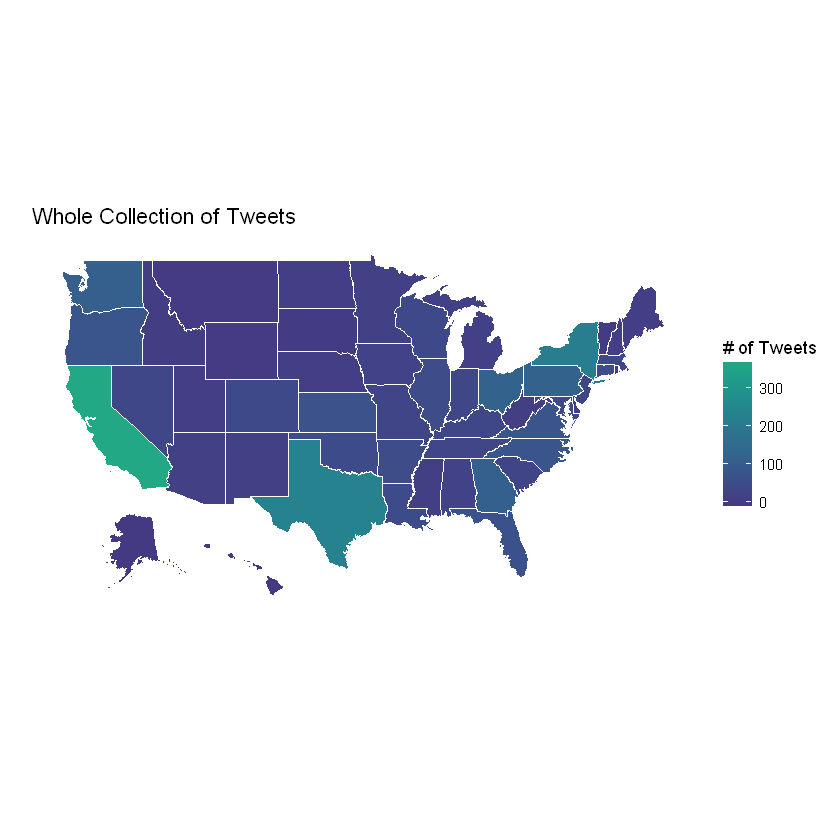

In [46]:
# Read the data and plot
gg <- ggplot() + geom_map(data = states, map = fifty_states, 
                    aes(fill=freq, map_id = region), 
                    color = 'white', size = 0.5) +
        expand_limits(x = fifty_states$long, y = fifty_states$lat) + coord_map() 
gg <- gg + scale_fill_viridis(name = "# of Tweets",
                              begin = 0.17, end =0.6)
gg <- gg + ggtitle("Whole Collection of Tweets")
gg <- gg + scale_x_continuous(breaks = NULL) + 
  scale_y_continuous(breaks = NULL) +
  labs(x = "", y = "") +
  theme(panel.background = element_blank())
gg

Plot Map with two keywords

In [47]:
mapData <- read.csv("Files/filteredByKeyWords.csv")
# Create a table with States and the frequency
states2 <- as.data.frame(table(mapData$state))

In [48]:
# Create coord for each states
usa <- map_data("state")
# List of all states in the US
listOfStates <- unique(fifty_states$id) 
# Change column names of state df
colnames(states2) <- c("region", "freq")

# In case we did not recieve tweets from any states, set default value
for (s in listOfStates){
    if (!(s %in% states2$region)){
        states2 <- rbind(states2, data.frame( region = s, freq = 0))
    }
}

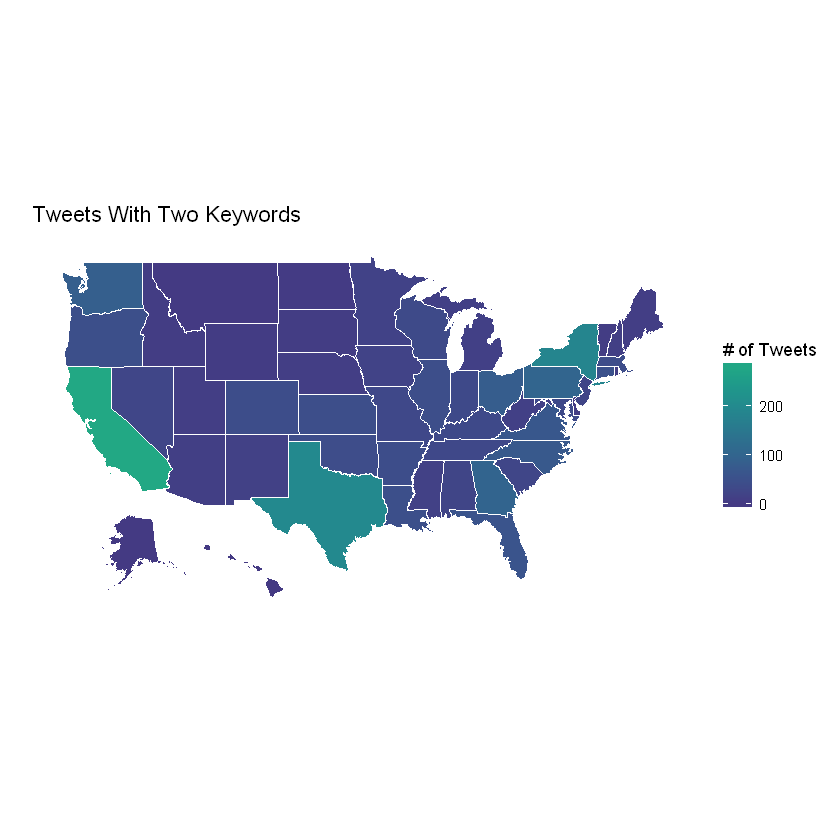

In [49]:
# Read the data and plot
gg <- ggplot() + geom_map(data = states2, map = fifty_states, 
                    aes(fill=freq, map_id = region), 
                    color = 'white', size = 0.5) +
        expand_limits(x = fifty_states$long, y = fifty_states$lat) + coord_map() 
gg <- gg + scale_fill_viridis(name = "# of Tweets",
                              begin = 0.17, end =0.6)
gg <- gg + ggtitle("Tweets With Two Keywords")
gg <- gg + scale_x_continuous(breaks = NULL) + 
  scale_y_continuous(breaks = NULL) +
  labs(x = "", y = "") +
  theme(panel.background = element_blank())
gg

# Shiny

In [ ]:
#ui controls front end
ui <- fluidPage(theme = "bootstrap.css",
  titlePanel("Map"),
  fluidRow(class = "Row1", 
           column(6,wellPanel(
             selectInput("var", label="Select a map to compare:",
                         choices = c("CDC vs Twitter" = "Main", "CDC vs Keyword"="Second"))
           )),
           column(6,imageOutput("CDC"))),
  fluidRow(class = "Row2",
           # Add text
           column(6, textOutput("description")),
           column(6,imageOutput("image1")))
  , tags$head(tags$style("
                         .Row1{height:200px;}
                         .Row2{height:350px;background-color: cornsilk;}"
  )
  )
)

#server controls backend
server <- function(input,output){
    output$CDC <- renderImage({ list(src="CDC.png", width =650, height =400, fileType = "image/png")},deleteFile = FALSE)
    output$image1 <- renderImage({
        #decision structure for selecting output map based on input
      if (input$var == "Main"){
        list(src="MainMap.png", width = 650, height = 400, fileType="image/png")
      }else if (input$var == "Second"){
        list(src="Keywords.png", width = 650, height = 400, fileType="image/png")
      }
      
    }, deleteFile=FALSE)
    output$description <- renderText(
        #decision structure for selecting output text based on input
      if (input$var == "Main"){
        "Based on the collection of tweets compared with the map from the CDC, a large amount of tweets\n are from the states with the greatest population,
         namely California, Texas, and New York. In contrast, the area with the highest level of Flu activity were in the South, interestingly centered around Texas. Texas may have
        generated so many matching tweets not only because of its large population, but also because of its high level of Flu activity."
      }else if (input$var == "Second"){
        "The key words we used to collect the most tweets were #Flu and #FluSeason. This map again demonstrates a similar spatial distribution as our total collection of tweets,
         largely because these keywords were responsible for most of the data collected. California, the state with the largest population, had the most matching tweets of any state. 
        The next step in this analysis would be not to only compare total amount of tweets versus Flu activity, but rather tweets per capita versus Flu activity."
      }
    )
}


shinyApp(ui = ui, server = server)



Listening on http://127.0.0.1:3923
